### 2D Slice Training

In [ ]:
# Full CNN Training Pipeline with Logging and Model Saving

import os
import numpy as np
import pandas as pd
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import SimpleITK as sitk
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from collections import Counter
from tqdm import tqdm
import json

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)  # Define IMG_SIZE before the model
OUTPUT_DIR = "./output"  # Define output directory

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------- Model ---------------- #
class CNNClassifier(nn.Module):
    def __init__(self, img_size=IMG_SIZE):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.5)
        # Calculate the size after 2 pooling operations
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # Use squeeze(-1) to only remove the last dimension, not all size-1 dimensions
        return self.fc2(x).squeeze(-1)

# ---------------- Dataset ---------------- #
class MostMaskSliceDataset(Dataset):
    def __init__(self, patient_ids, img_size=(256, 256), transform=None, num_slices=5):
        self.samples = []
        self.img_size = img_size
        self.transform = transform

        # Load quality scores CSV once
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        for pid in patient_ids:
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_resampled_mask.nii.gz"
            if not (os.path.exists(img_path) and os.path.exists(mask_path)):
                continue

            # Get label from CSV
            if pid not in qs_df.index:
                print(f"Patient {pid} not found in quality scores CSV, skipping.", flush=True)
                continue
            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 1 if (expert_1 == "Good" and expert_2 == "Good") else 0

            try:
                img = nib.load(img_path).get_fdata()
                mask = nib.load(mask_path).get_fdata()
            except Exception as e:
                print(f"Error loading data for patient {pid}: {e}", flush=True)
                continue

            # Find top N slices with most mask pixels
            mask_sum = mask.sum(axis=(0, 1))
            num_slices_to_store = min(num_slices, mask.shape[2])
            best_slices = np.argsort(-mask_sum)[:num_slices_to_store]

            for best_slice in best_slices:
                img_slice = img[:, :, best_slice]
                mask_slice = mask[:, :, best_slice]

                # Normalize image
                img_slice = (img_slice - img_slice.mean()) / (img_slice.std() + 1e-8)
                # Stack image and mask as channels
                input_2ch = np.stack([img_slice, mask_slice], axis=0)
                # Resize if needed
                if self.img_size is not None and (img_slice.shape != self.img_size):
                    input_2ch = torch.tensor(input_2ch).unsqueeze(0)
                    input_2ch = torch.nn.functional.interpolate(
                        input_2ch, size=self.img_size, mode='bilinear', align_corners=False
                    ).squeeze(0).numpy()

                self.samples.append((input_2ch.astype(np.float32), label))
                print(f"Processed patient {pid}, slice={best_slice}, label={label}", flush=True)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        if self.transform:
            x = self.transform(x)
        return torch.tensor(x), torch.tensor(y, dtype=torch.float32)

# ----------------- Prepare Data ----------------- #
N_SPLITS = 5  # 5-fold cross-validation

all_patients = [d for d in os.listdir("../preprocessed") if os.path.isdir(os.path.join("../preprocessed", d))]

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(all_patients)):
    print(f"\n--- Fold {fold+1}/{N_SPLITS} ---", flush=True)
    train_ids = [all_patients[i] for i in train_idx]
    val_ids = [all_patients[i] for i in val_idx]

    train_dataset = MostMaskSliceDataset(train_ids, img_size=IMG_SIZE)
    val_dataset = MostMaskSliceDataset(val_ids, img_size=IMG_SIZE)

    # Calculate weights for each sample in the train dataset
    labels = [label for _, label in train_dataset.samples]
    # Your proportions
    bad_weight = 1 / 0.2736
    good_weight = 1 / 0.7264
    sample_weights = [good_weight if l == 1 else bad_weight for l in labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    model = CNNClassifier().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()  # <-- Use BCEWithLogitsLoss

    training_logs = []
    best_accuracy = 0.0  # Track best accuracy for saving best model

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{EPOCHS}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Fold {fold+1} Train Loss: {avg_train_loss:.4f}", flush=True)

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).float()  # Apply sigmoid for thresholding
                
                # Ensure outputs are always 1D tensors
                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
                if preds.dim() == 0:
                    preds = preds.unsqueeze(0)
                if labels.dim() == 0:
                    labels = labels.unsqueeze(0)
                
                # Convert to numpy and extend
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Convert to numpy arrays for metrics calculation
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        accuracy = np.mean(all_preds == all_labels)
        
        # Handle edge cases for metrics calculation
        try:
            f1 = f1_score(all_labels, all_preds)
        except:
            f1 = 0.0
            print(f"Warning: Could not calculate F1 score for fold {fold+1}, epoch {epoch+1}", flush=True)
            
        try:
            precision = precision_score(all_labels, all_preds)
        except:
            precision = 0.0
            print(f"Warning: Could not calculate precision for fold {fold+1}, epoch {epoch+1}", flush=True)
            
        try:
            recall = recall_score(all_labels, all_preds)
        except:
            recall = 0.0
            print(f"Warning: Could not calculate recall for fold {fold+1}, epoch {epoch+1}", flush=True)
            
        try:
            auc = roc_auc_score(all_labels, all_preds)
        except:
            auc = 0.5  # Default to random performance
            print(f"Warning: Could not calculate AUC for fold {fold+1}, epoch {epoch+1}", flush=True)

        print(f"Fold {fold+1} Validation Accuracy: {accuracy:.4f}", flush=True)
        print(f"Fold {fold+1} F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}", flush=True)

        # Save model and metrics
        fold_output_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
        os.makedirs(fold_output_dir, exist_ok=True)
        
        # Save model state dict
        torch.save(model.state_dict(), os.path.join(fold_output_dir, f"model_epoch_{epoch+1}.pt"))
        
        # Save full model (for easier loading)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'accuracy': accuracy,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'auc': auc
        }, os.path.join(fold_output_dir, f"checkpoint_epoch_{epoch+1}.pt"))

        training_logs.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "accuracy": accuracy,
            "f1": f1,
            "precision": precision,
            "recall": recall,
            "auc": auc
        })

        # Save logs after each epoch
        with open(os.path.join(fold_output_dir, "training_log.json"), "w") as f:
            json.dump(training_logs, f, indent=4)

        pd.DataFrame(training_logs).to_csv(os.path.join(fold_output_dir, "training_log.csv"), index=False)
        
        # Save best model based on validation accuracy
        if epoch == 0 or accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': accuracy,
                'f1': f1,
                'precision': precision,
                'recall': recall,
                'auc': auc
            }, os.path.join(fold_output_dir, "best_model.pt"))
            print(f"Fold {fold+1} New best model saved with accuracy: {accuracy:.4f}", flush=True)


### Creating Balanced Subsets

In [4]:
# --- Imports ---
import pandas as pd

# --- Config ---
CSV_PATH = "../preliminary_automatic_segmentations_quality_scores.csv"
SPLIT_CSV_PATH = "../train_test_splits.csv"
SAMPLE_SIZES = [200, 400, None]  # None means use largest possible valid

# Desired proportions
TRAIN_RATIO = 0.745
TEST_RATIO = 0.255
GOOD_RATIO = 0.5
BAD_RATIO = 0.5

# --- Load CSVs ---
df = pd.read_csv(CSV_PATH)
split_df = pd.read_csv(SPLIT_CSV_PATH)

# --- Filter Non-DUKE ---
non_duke = df[~df['patient_id'].str.startswith('DUKE')]
both_good = (non_duke['expert_1_qs'] == 'Good') & (non_duke['expert_2_qs'] == 'Good')

# --- Get Train/Test IDs ---
train_ids = split_df['train_split'].dropna().tolist()
test_ids = split_df['test_split'].dropna().tolist()

# --- Define 4 buckets ---
train_good = non_duke[non_duke['patient_id'].isin(train_ids) & both_good]
train_bad = non_duke[non_duke['patient_id'].isin(train_ids) & ~both_good]
test_good = non_duke[non_duke['patient_id'].isin(test_ids) & both_good]
test_bad = non_duke[non_duke['patient_id'].isin(test_ids) & ~both_good]

print("Train Good:", len(train_good))
print("Train Bad:", len(train_bad))
print("Test Good:", len(test_good))
print("Test Bad:", len(test_bad))

# --- Proportion targets ---
train_good_pct = TRAIN_RATIO * GOOD_RATIO  # 0.3725
train_bad_pct = TRAIN_RATIO * BAD_RATIO    # 0.3725
test_good_pct = TEST_RATIO * GOOD_RATIO    # 0.1275
test_bad_pct = TEST_RATIO * BAD_RATIO      # 0.1275

# --- Calculate max feasible total ---
max_train_good = len(train_good) / train_good_pct if train_good_pct > 0 else float('inf')
max_train_bad  = len(train_bad)  / train_bad_pct if train_bad_pct > 0 else float('inf')
max_test_good  = len(test_good)  / test_good_pct if test_good_pct > 0 else float('inf')
max_test_bad   = len(test_bad)   / test_bad_pct if test_bad_pct > 0 else float('inf')

max_possible_total = int(min(max_train_good, max_train_bad, max_test_good, max_test_bad))

print(f"Max possible balanced total: {max_possible_total}")

# --- Final sizes ---
final_sample_sizes = []
for size in SAMPLE_SIZES:
    if size is None:
        size = (max_possible_total // 2) * 2  # force even number
    final_sample_sizes.append(size)

print("Final sizes:", final_sample_sizes)

# --- Create splits ---
for total_size in final_sample_sizes:
    # Target per group
    train_good_n = int(round(total_size * train_good_pct))
    train_bad_n  = int(round(total_size * train_bad_pct))
    test_good_n  = int(round(total_size * test_good_pct))
    test_bad_n   = int(round(total_size * test_bad_pct))

    # Auto adjust if any too large
    train_good_n = min(train_good_n, len(train_good))
    train_bad_n  = min(train_bad_n, len(train_bad))
    test_good_n  = min(test_good_n, len(test_good))
    test_bad_n   = min(test_bad_n, len(test_bad))

    # Effective new total
    actual_total = train_good_n + train_bad_n + test_good_n + test_bad_n

    # Sample each
    sampled_train_good = train_good.sample(train_good_n, random_state=42)
    sampled_train_bad  = train_bad.sample(train_bad_n, random_state=42)
    sampled_test_good  = test_good.sample(test_good_n, random_state=42)
    sampled_test_bad   = test_bad.sample(test_bad_n, random_state=42)

    # Merge
    final_train = pd.concat([sampled_train_good, sampled_train_bad]).sample(frac=1, random_state=42)
    final_test  = pd.concat([sampled_test_good, sampled_test_bad]).sample(frac=1, random_state=42)

    # Save
    final_train.to_csv(f"../preprocess/non_duke_train_{actual_total}.csv", index=False)
    final_test.to_csv(f"../preprocess/non_duke_test_{actual_total}.csv", index=False)

    print(f"✅ Saved: Train={len(final_train)}, Test={len(final_test)}, Total={actual_total}")


Train Good: 438
Train Bad: 562
Test Good: 78
Test Bad: 137
Max possible balanced total: 611
Final sizes: [200, 400, 610]
✅ Saved: Train=148, Test=52, Total=200
✅ Saved: Train=298, Test=102, Total=400
✅ Saved: Train=454, Test=156, Total=610


In [2]:
import os
import pandas as pd
import SimpleITK as sitk

# --------- Config ----------
IMG_SIZE = (384, 384)

train_csv = '../preprocess/non_duke_train_610.csv'
train_ids = pd.read_csv(train_csv)['patient_id'].astype(str).tolist()

qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
qs_df = qs_df.set_index("patient_id")

for i, pid in enumerate(train_ids):
    img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
    mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"

    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        continue
    if pid not in qs_df.index:
        continue

    img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
    mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

    print(f"Patient {pid}: img shape = {img.shape}, mask shape = {mask.shape}")

    for z in range(mask.shape[2]):
        if mask[:, :, z].sum() == 0:
            continue

        slice_img = img[:, :, z]
        slice_mask = mask[:, :, z]
        if slice_img.shape != IMG_SIZE or slice_mask.shape != IMG_SIZE:
            print(f" ⚠️  Z-slice {z} has unexpected shape: img={slice_img.shape} mask={slice_mask.shape}")

print("✅ Done checking shapes.")


Patient ISPY2_692885: img shape = (192, 384, 384), mask shape = (192, 384, 384)
 ⚠️  Z-slice 152 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 153 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 154 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 155 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 156 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 157 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 158 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 159 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 160 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 161 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 162 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 163 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-slice 164 has unexpected shape: img=(192, 384) mask=(192, 384)
 ⚠️  Z-sli

In [2]:
# --- Imports ---
import pandas as pd

# --- Config ---
CSV_PATH = "../preliminary_automatic_segmentations_quality_scores.csv"
SPLIT_CSV_PATH = "../train_test_splits.csv"
HIGH_OVERLAP_PATH = "../preprocess/high_overlap_patients.txt"
SAMPLE_SIZES = [200, 300, None]  # None = largest possible valid

# Desired proportions
TRAIN_RATIO = 0.745
TEST_RATIO = 0.255
GOOD_RATIO = 0.5
BAD_RATIO = 0.5

# --- Load data ---
df = pd.read_csv(CSV_PATH)
split_df = pd.read_csv(SPLIT_CSV_PATH)

# --- Load high-overlap patient IDs ---
with open(HIGH_OVERLAP_PATH, 'r') as f:
    high_overlap_ids = set(line.strip() for line in f if line.strip())

# --- Filter Non-DUKE & High Overlap ---
non_duke = df[~df['patient_id'].str.startswith('DUKE')]
non_duke = non_duke[non_duke['patient_id'].isin(high_overlap_ids)]

# --- Label Good/Bad ---
both_good = (non_duke['expert_1_qs'] == 'Good') & (non_duke['expert_2_qs'] == 'Good')

# --- Get Train/Test IDs ---
train_ids = split_df['train_split'].dropna().tolist()
test_ids = split_df['test_split'].dropna().tolist()

# --- Define 4 buckets ---
train_good = non_duke[non_duke['patient_id'].isin(train_ids) & both_good]
train_bad = non_duke[non_duke['patient_id'].isin(train_ids) & ~both_good]
test_good = non_duke[non_duke['patient_id'].isin(test_ids) & both_good]
test_bad = non_duke[non_duke['patient_id'].isin(test_ids) & ~both_good]

print("Train Good:", len(train_good))
print("Train Bad:", len(train_bad))
print("Test Good:", len(test_good))
print("Test Bad:", len(test_bad))

# --- Proportion targets ---
train_good_pct = TRAIN_RATIO * GOOD_RATIO  # 0.3725
train_bad_pct  = TRAIN_RATIO * BAD_RATIO   # 0.3725
test_good_pct  = TEST_RATIO * GOOD_RATIO   # 0.1275
test_bad_pct   = TEST_RATIO * BAD_RATIO    # 0.1275

# --- Calculate max feasible total ---
max_train_good = len(train_good) / train_good_pct if train_good_pct > 0 else float('inf')
max_train_bad  = len(train_bad)  / train_bad_pct if train_bad_pct > 0 else float('inf')
max_test_good  = len(test_good)  / test_good_pct if test_good_pct > 0 else float('inf')
max_test_bad   = len(test_bad)   / test_bad_pct if test_bad_pct > 0 else float('inf')

max_possible_total = int(min(max_train_good, max_train_bad, max_test_good, max_test_bad))

print(f"Max possible balanced total: {max_possible_total}")

# --- Final sample sizes ---
final_sample_sizes = []
for size in SAMPLE_SIZES:
    if size is None:
        size = (max_possible_total // 2) * 2  # force even
    final_sample_sizes.append(size)

print("Final sample sizes:", final_sample_sizes)

# --- Create splits ---
for total_size in final_sample_sizes:
    # Target per group
    train_good_n = int(round(total_size * train_good_pct))
    train_bad_n  = int(round(total_size * train_bad_pct))
    test_good_n  = int(round(total_size * test_good_pct))
    test_bad_n   = int(round(total_size * test_bad_pct))

    # Cap by available
    train_good_n = min(train_good_n, len(train_good))
    train_bad_n  = min(train_bad_n, len(train_bad))
    test_good_n  = min(test_good_n, len(test_good))
    test_bad_n   = min(test_bad_n, len(test_bad))

    # Actual new total
    actual_total = train_good_n + train_bad_n + test_good_n + test_bad_n

    # Sample
    sampled_train_good = train_good.sample(train_good_n, random_state=42)
    sampled_train_bad  = train_bad.sample(train_bad_n, random_state=42)
    sampled_test_good  = test_good.sample(test_good_n, random_state=42)
    sampled_test_bad   = test_bad.sample(test_bad_n, random_state=42)

    # Merge & shuffle
    final_train = pd.concat([sampled_train_good, sampled_train_bad]).sample(frac=1, random_state=42)
    final_test  = pd.concat([sampled_test_good, sampled_test_bad]).sample(frac=1, random_state=42)

    # Save
    final_train.to_csv(f"../preprocess/high_overlap_non_duke_train_{actual_total}.csv", index=False)
    final_test.to_csv(f"../preprocess/high_overlap_non_duke_test_{actual_total}.csv", index=False)

    print(f"✅ Saved: Train={len(final_train)}, Test={len(final_test)}, Total={actual_total}")


Train Good: 340
Train Bad: 293
Test Good: 49
Test Bad: 88
Max possible balanced total: 384
Final sample sizes: [200, 300, 384]
✅ Saved: Train=148, Test=52, Total=200
✅ Saved: Train=224, Test=76, Total=300
✅ Saved: Train=286, Test=98, Total=384


## Models

### Max Pooling

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# Logging config
LOG_SLICE_STATS = True  # Whether to log slice logit statistics

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze(-1)  # [batch]

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_ids, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        for pid in patient_ids:
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            if pid not in qs_df.index:
                continue

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 1 if (expert_1 == "Good" and expert_2 == "Good") else 0

            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

            slices = []
            for i in range(mask.shape[0]):
                if mask[i, :, :].sum() == 0:
                    continue
                img_slice = img[i, :, :]
                mask_slice = mask[i, :, :]
                slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                slices.append(slice_tensor)

            if len(slices) > 0:
                patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
train_file = '../preprocess/train_patients_overlapped.txt'
test_file = '../preprocess/test_patients_overlapped.txt'

with open(train_file, 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]
with open(test_file, 'r') as f:
    test_ids = [line.strip() for line in f.readlines()]

train_dataset = AllSlicesDataset(train_ids)
test_dataset = AllSlicesDataset(test_ids)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = CNNBackbone().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

training_logs = []
slice_stats_logs = []  # For logging slice statistics
best_val_f1 = -1
best_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    epoch_slice_stats = []  # Collect slice stats for this epoch
    
    for patient_slices, patient_label in tqdm(train_loader):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
        patient_label = patient_label.to(DEVICE)               # [1]

        optimizer.zero_grad()
        slice_logits = model(patient_slices)  # [Num_slices]
        slice_logits = -slice_logits  # Invert: high logits = bad masks
        
        # Use max pooling instead of weighted sum
        volume_logit = torch.max(slice_logits)  # scalar - max pooling
        
        # Log slice statistics if enabled
        if LOG_SLICE_STATS:
            slice_max = torch.max(slice_logits).item()
            slice_min = torch.min(slice_logits).item()
            slice_mean = torch.mean(slice_logits).item()
            epoch_slice_stats.append({
                'epoch': epoch + 1,
                'phase': 'train',
                'slice_max': slice_max,
                'slice_min': slice_min,
                'slice_mean': slice_mean,
                'num_slices': len(slice_logits)
            })
        
        scaled_logit = volume_logit / TEMPERATURE
        loss = criterion(scaled_logit.unsqueeze(0), patient_label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # For train accuracy
        pred = torch.sigmoid(scaled_logit).item()
        train_preds.append(1 if pred > 0.5 else 0)
        train_labels.append(int(patient_label.item()))

    avg_train_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}", flush=True)
    print(f"Epoch {epoch+1} Train Acc: {train_acc:.4f}", flush=True)

    # Eval
    model.eval()
    preds, labels = [], []
    val_running_loss = 0.0
    val_slice_stats = []  # Collect validation slice stats
    
    with torch.no_grad():
        for patient_slices, patient_label in test_loader:
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.item()
            slice_logits = model(patient_slices)
            slice_logits = -slice_logits  # Invert: high logits = bad masks
            
            # Use max pooling instead of weighted sum
            volume_logit = torch.max(slice_logits)  # scalar - max pooling
            
            # Log slice statistics if enabled
            if LOG_SLICE_STATS:
                slice_max = torch.max(slice_logits).item()
                slice_min = torch.min(slice_logits).item()
                slice_mean = torch.mean(slice_logits).item()
                val_slice_stats.append({
                    'epoch': epoch + 1,
                    'phase': 'val',
                    'slice_max': slice_max,
                    'slice_min': slice_min,
                    'slice_mean': slice_mean,
                    'num_slices': len(slice_logits)
                })
            
            scaled_logit = volume_logit / TEMPERATURE
            pred = torch.sigmoid(scaled_logit).item()
            preds.append(1 if pred > 0.5 else 0)
            labels.append(int(patient_label))
            # Validation loss
            val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
            val_running_loss += val_loss.item()

    acc = np.mean(np.array(preds) == np.array(labels))
    avg_val_loss = val_running_loss / len(test_loader)
    try:
        precision = precision_score(labels, preds)
    except:
        precision = 0.0
    try:
        recall = recall_score(labels, preds)
    except:
        recall = 0.0
    try:
        f1 = f1_score(labels, preds)
    except:
        f1 = 0.0

    print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}", flush=True)

    # Save logs
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "val_loss": avg_val_loss,
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1
    })
    
    # Save slice statistics logs
    if LOG_SLICE_STATS:
        slice_stats_logs.extend(epoch_slice_stats)
        slice_stats_logs.extend(val_slice_stats)

    fold_dir = os.path.join(OUTPUT_DIR, f"run")
    os.makedirs(fold_dir, exist_ok=True)

    with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

    pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)
    
    # Save slice statistics
    if LOG_SLICE_STATS:
        with open(os.path.join(fold_dir, "slice_stats_log.json"), "w") as f:
            json.dump(slice_stats_logs, f, indent=4)
        
        pd.DataFrame(slice_stats_logs).to_csv(os.path.join(fold_dir, "slice_stats_log.csv"), index=False)

    # Early stopping logic
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        # Save best model so far
        torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
        break


### Softmax

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze(-1)  # [batch]

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_ids, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")
        
        # Load bounding box information
        bbox_df = pd.read_csv("../filter/overlapped_patients_bbox_115.txt", 
                             sep=' ', header=None, names=['patient_id', 'start_slice', 'end_slice'])
        bbox_df = bbox_df.set_index("patient_id")

        for pid in patient_ids:
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            if pid not in qs_df.index:
                continue
                
            # Get bounding box for this patient
            if pid not in bbox_df.index:
                continue
                
            start_slice = bbox_df.loc[pid, "start_slice"]
            end_slice = bbox_df.loc[pid, "end_slice"]

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

            slices = []
            # Only process slices within the bounding box range
            for i in range(start_slice, end_slice + 1):
                if i >= mask.shape[0] or mask[i, :, :].sum() == 0:
                    continue
                img_slice = img[i, :, :]
                mask_slice = mask[i, :, :]
                slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                slices.append(slice_tensor)

            if len(slices) > 0:
                patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
train_file = '../filter/train_patients_overlapped.txt'
test_file = '../filter/test_patients_overlapped.txt'

with open(train_file, 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]
with open(test_file, 'r') as f:
    test_ids = [line.strip() for line in f.readlines()]

train_dataset = AllSlicesDataset(train_ids)
test_dataset = AllSlicesDataset(test_ids)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = CNNBackbone().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

training_logs = []
best_val_f1 = -1
best_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    for patient_slices, patient_label in tqdm(train_loader):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
        patient_label = patient_label.to(DEVICE)               # [1]

        optimizer.zero_grad()
        slice_logits = model(patient_slices)  # [Num_slices]
        weights = torch.softmax(slice_logits, dim=0)  # [Num_slices]
        volume_logit = torch.sum(weights * slice_logits)  # scalar
        scaled_logit = volume_logit / TEMPERATURE
        loss = criterion(scaled_logit.unsqueeze(0), patient_label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # For train accuracy
        pred = torch.sigmoid(scaled_logit).item()
        train_preds.append(1 if pred > 0.5 else 0)
        train_labels.append(int(patient_label.item()))

    avg_train_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}", flush=True)

    # Eval
    model.eval()
    preds, labels = [], []
    val_running_loss = 0.0
    with torch.no_grad():
        for patient_slices, patient_label in test_loader:
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.item()
            slice_logits = model(patient_slices)
            weights = torch.softmax(slice_logits, dim=0)
            volume_logit = torch.sum(weights * slice_logits)
            scaled_logit = volume_logit / TEMPERATURE
            pred = torch.sigmoid(scaled_logit).item()
            preds.append(1 if pred > 0.5 else 0)
            labels.append(int(patient_label))
            # Validation loss
            val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
            val_running_loss += val_loss.item()

    acc = np.mean(np.array(preds) == np.array(labels))
    avg_val_loss = val_running_loss / len(test_loader)
    try:
        precision = precision_score(labels, preds)
    except:
        precision = 0.0
    try:
        recall = recall_score(labels, preds)
    except:
        recall = 0.0
    try:
        f1 = f1_score(labels, preds)
    except:
        f1 = 0.0

    print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}", flush=True)

    # Save logs
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "val_loss": avg_val_loss,
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1
    })

    fold_dir = os.path.join(OUTPUT_DIR, f"run")
    os.makedirs(fold_dir, exist_ok=True)

    with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

    pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)

    # Early stopping logic
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        # Save best model so far
        torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
        break

### Attention Learning

In [ ]:
import re
import matplotlib.pyplot as plt

# Parse the log file
import os
log_dir = "logs"
log_files = [f for f in os.listdir(log_dir) if f.startswith("cnn_") and f.endswith(".out")]
log_files.sort(key=lambda x: os.path.getmtime(os.path.join(log_dir, x)))
log_file = os.path.join(log_dir, log_files[-1])
print(f"Using log file: {log_file}")
epochs = []
train_loss = []
train_acc = []
train_auc = []
val_acc = []
val_loss = []
val_auc = []
precision = []
recall = []
f1 = []

with open(log_file, "r") as f:
    for line in f:
        # Match train line with AUC
        m_train = re.match(
            r"Epoch (\d+) Train Loss: ([\d\.]+) \| Train Acc: ([\d\.]+) \| Train AUC: ([\d\.]+)", line)
        if m_train:
            epochs.append(int(m_train.group(1)))
            train_loss.append(float(m_train.group(2)))
            train_acc.append(float(m_train.group(3)))
            train_auc.append(float(m_train.group(4)))
            continue
        # Match val line with AUC
        m_val = re.match(
            r"Epoch (\d+) Val Acc: ([\d\.]+) \| Val Loss: ([\d\.]+) \| Precision: ([\d\.]+) \| Recall: ([\d\.]+) \| F1: ([\d\.]+) \| AUC: ([\d\.]+)",
            line)
        if m_val:
            # val epoch should match train epoch
            val_acc.append(float(m_val.group(2)))
            val_loss.append(float(m_val.group(3)))
            precision.append(float(m_val.group(4)))
            recall.append(float(m_val.group(5)))
            f1.append(float(m_val.group(6)))
            val_auc.append(float(m_val.group(7)))

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(epochs, train_loss, label="Train Loss")
axs[0, 0].plot(epochs, val_loss, label="Val Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Loss over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epochs, train_acc, label="Train Acc")
axs[0, 1].plot(epochs, val_acc, label="Val Acc")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].set_title("Accuracy over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(epochs, precision, label="Precision")
axs[1, 0].plot(epochs, recall, label="Recall")
axs[1, 0].plot(epochs, f1, label="F1")
axs[1, 0].plot(epochs, val_auc, label="Val AUC")
axs[1, 0].plot(epochs, train_auc, label="Train AUC", linestyle="--")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Score")
axs[1, 0].set_title("Precision, Recall, F1, AUC over Epochs")
axs[1, 0].legend()

axs[1, 1].axis('off')  # Empty

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# Entropy regularization config
ENTROPY_REG_WEIGHT = 0.01  # Weight for entropy regularization (encourages uniform attention)

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE, attn_dropout=0.3):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.slice_classifier = nn.Linear(64, 1)  # slice-level prediction
        self.slice_attn = nn.Linear(64, 1)        # slice-level attention weight
        self.attn_dropout = nn.Dropout(attn_dropout)  # Dropout for attention weights

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        logit = self.slice_classifier(x).squeeze(-1)  # [num_slices]
        attn_weight = self.slice_attn(x).squeeze(-1)  # [num_slices]
        # Apply dropout to attention weights
        attn_weight = self.attn_dropout(attn_weight)
        return logit, attn_weight

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_boundaries, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        for pid, start_slice, end_slice in patient_boundaries:
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            if pid not in qs_df.index:
                continue

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

            slices = []
            # Only process slices within the bounding box range
            for i in range(start_slice, end_slice + 1):
                if i >= mask.shape[0] or mask[i, :, :].sum() == 0:
                    continue
                img_slice = img[i, :, :]
                mask_slice = mask[i, :, :]
                slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                slices.append(slice_tensor)

            if len(slices) > 0:
                patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
def load_patient_boundaries(file_path):
    """Load patient boundaries from file with format: patient_id start_slice end_slice"""
    boundaries = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                patient_id = parts[0]
                start_slice = int(parts[1])
                end_slice = int(parts[2])
                boundaries.append((patient_id, start_slice, end_slice))
    return boundaries

train_file = '../filter/bbox-com/nonduke_patients_boundary_train.txt'
test_file = '../filter/bbox-com/nonduke_patients_boundary_test.txt'

train_boundaries = load_patient_boundaries(train_file)
test_boundaries = load_patient_boundaries(test_file)

train_dataset = AllSlicesDataset(train_boundaries)
test_dataset = AllSlicesDataset(test_boundaries)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = CNNBackbone().to(DEVICE)
# Add weight decay to optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

training_logs = []
best_val_f1 = -1
best_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    train_logits = []  # Store raw logits for training
    for patient_slices, patient_label in tqdm(train_loader):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
        patient_label = patient_label.to(DEVICE)               # [1]

        optimizer.zero_grad()
        slice_logits, slice_attn = model(patient_slices)  # [Num_slices], [Num_slices]
        weights = torch.softmax(slice_attn, dim=0)  # [Num_slices]
        volume_logit = torch.sum(weights * slice_logits)  # scalar
        scaled_logit = volume_logit / TEMPERATURE
        
        # Calculate main classification loss
        classification_loss = criterion(scaled_logit.unsqueeze(0), patient_label)
        
        # Calculate entropy regularization loss (encourages uniform attention)
        # Higher entropy = more uniform attention distribution
        entropy = -torch.sum(weights * torch.log(weights + 1e-8))  # Add small epsilon for numerical stability
        entropy_loss = -ENTROPY_REG_WEIGHT * entropy  # Negative because we want to maximize entropy
        
        # Total loss
        total_loss = classification_loss + entropy_loss
        
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item()

        # For train accuracy and logits
        pred = torch.sigmoid(scaled_logit).item()
        train_preds.append(1 if pred > 0.5 else 0)
        train_labels.append(int(patient_label.item()))
        train_logits.append(scaled_logit.item())  # Store raw logit

    avg_train_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    
    # Calculate training AUC
    try:
        train_auc = roc_auc_score(train_labels, train_logits)
    except:
        train_auc = 0.5  # Default to random performance
    
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}", flush=True)

    # Eval
    model.eval()
    preds, labels = [], []
    val_logits = []  # Store raw logits for validation
    val_running_loss = 0.0
    with torch.no_grad():
        for patient_slices, patient_label in test_loader:
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.item()
            slice_logits, slice_attn = model(patient_slices)
            weights = torch.softmax(slice_attn, dim=0)
            volume_logit = torch.sum(weights * slice_logits)
            scaled_logit = volume_logit / TEMPERATURE
            pred = torch.sigmoid(scaled_logit).item()
            preds.append(1 if pred > 0.5 else 0)
            labels.append(int(patient_label))
            val_logits.append(scaled_logit.item())  # Store raw logit
            # Validation loss (only classification loss, no entropy regularization)
            val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
            val_running_loss += val_loss.item()

    acc = np.mean(np.array(preds) == np.array(labels))
    avg_val_loss = val_running_loss / len(test_loader)
    
    # Calculate validation metrics including AUC
    try:
        precision = precision_score(labels, preds)
    except:
        precision = 0.0
    try:
        recall = recall_score(labels, preds)
    except:
        recall = 0.0
    try:
        f1 = f1_score(labels, preds)
    except:
        f1 = 0.0
    try:
        auc = roc_auc_score(labels, val_logits)
    except:
        auc = 0.5  # Default to random performance

    print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)

    # Save logs with logits and AUC
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "train_auc": train_auc,
        "val_loss": avg_val_loss,
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_auc": auc,
        "train_logits_mean": np.mean(train_logits),
        "train_logits_std": np.std(train_logits),
        "val_logits_mean": np.mean(val_logits),
        "val_logits_std": np.std(val_logits)
    })

    fold_dir = os.path.join(OUTPUT_DIR, f"run")
    os.makedirs(fold_dir, exist_ok=True)

    with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

    pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)

    # Early stopping logic
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        # Save best model so far
        torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
        break

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# Parameter sweep grid
PARAMETER_SWEEP = [
    {"entropy_weight": 0.001, "attn_dropout": 0.1, "weight_decay": 1e-4},
    {"entropy_weight": 0.001, "attn_dropout": 0.05, "weight_decay": 1e-4},
    {"entropy_weight": 0.001, "attn_dropout": 0.0, "weight_decay": 1e-4},
    {"entropy_weight": 0.0005, "attn_dropout": 0.1, "weight_decay": 1e-4},
    {"entropy_weight": 0.0001, "attn_dropout": 0.1, "weight_decay": 1e-4},
    {"entropy_weight": 0.0001, "attn_dropout": 0.05, "weight_decay": 1e-4},
]

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE, attn_dropout=0.1):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.slice_classifier = nn.Linear(64, 1)  # slice-level prediction
        self.slice_attn = nn.Linear(64, 1)        # slice-level attention weight
        self.attn_dropout = nn.Dropout(attn_dropout)  # Dropout for attention weights

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        logit = self.slice_classifier(x).squeeze(-1)  # [num_slices]
        attn_weight = self.slice_attn(x).squeeze(-1)  # [num_slices]
        # Apply dropout to attention weights
        attn_weight = self.attn_dropout(attn_weight)
        return logit, attn_weight

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_boundaries, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        for pid, start_slice, end_slice in patient_boundaries:
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            if pid not in qs_df.index:
                continue

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

            slices = []
            # Only process slices within the bounding box range
            for i in range(start_slice, end_slice + 1):
                if i >= mask.shape[0] or mask[i, :, :].sum() == 0:
                    continue
                img_slice = img[i, :, :]
                mask_slice = mask[i, :, :]
                slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                slices.append(slice_tensor)

            if len(slices) > 0:
                patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
def load_patient_boundaries(file_path):
    """Load patient boundaries from file with format: patient_id start_slice end_slice"""
    boundaries = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                patient_id = parts[0]
                start_slice = int(parts[1])
                end_slice = int(parts[2])
                boundaries.append((patient_id, start_slice, end_slice))
    return boundaries

train_file = '../filter/bbox-com/nonduke_patients_boundary_train.txt'
test_file = '../filter/bbox-com/nonduke_patients_boundary_test.txt'

train_boundaries = load_patient_boundaries(train_file)
test_boundaries = load_patient_boundaries(test_file)

train_dataset = AllSlicesDataset(train_boundaries)
test_dataset = AllSlicesDataset(test_boundaries)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ---------- Parameter Sweep Training ----------
def train_with_parameters(entropy_weight, attn_dropout, weight_decay, experiment_name):
    """Train model with specific parameters"""
    print(f"\n{'='*60}")
    print(f"Starting experiment: {experiment_name}")
    print(f"Parameters: entropy_weight={entropy_weight}, attn_dropout={attn_dropout}, weight_decay={weight_decay}")
    print(f"{'='*60}")
    
    model = CNNBackbone(attn_dropout=attn_dropout).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    training_logs = []
    best_val_f1 = -1
    best_epoch = -1
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        train_logits = []  # Store raw logits for training
        for patient_slices, patient_label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
            patient_label = patient_label.to(DEVICE)               # [1]

            optimizer.zero_grad()
            slice_logits, slice_attn = model(patient_slices)  # [Num_slices], [Num_slices]
            weights = torch.softmax(slice_attn, dim=0)  # [Num_slices]
            volume_logit = torch.sum(weights * slice_logits)  # scalar
            scaled_logit = volume_logit / TEMPERATURE
            
            # Calculate main classification loss
            classification_loss = criterion(scaled_logit.unsqueeze(0), patient_label)
            
            # Calculate entropy regularization loss (encourages uniform attention)
            # Higher entropy = more uniform attention distribution
            entropy = -torch.sum(weights * torch.log(weights + 1e-8))  # Add small epsilon for numerical stability
            entropy_loss = -entropy_weight * entropy  # Negative because we want to maximize entropy
            
            # Total loss
            total_loss = classification_loss + entropy_loss
            
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            # For train accuracy and logits
            pred = torch.sigmoid(scaled_logit).item()
            train_preds.append(1 if pred > 0.5 else 0)
            train_labels.append(int(patient_label.item()))
            train_logits.append(scaled_logit.item())  # Store raw logit

        avg_train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
        
        # Calculate training AUC
        try:
            train_auc = roc_auc_score(train_labels, train_logits)
        except:
            train_auc = 0.5  # Default to random performance
        
        print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}", flush=True)

        # Eval
        model.eval()
        preds, labels = [], []
        val_logits = []  # Store raw logits for validation
        val_running_loss = 0.0
        with torch.no_grad():
            for patient_slices, patient_label in test_loader:
                patient_slices = patient_slices.squeeze(0).to(DEVICE)
                patient_label = patient_label.item()
                slice_logits, slice_attn = model(patient_slices)
                weights = torch.softmax(slice_attn, dim=0)
                volume_logit = torch.sum(weights * slice_logits)
                scaled_logit = volume_logit / TEMPERATURE
                pred = torch.sigmoid(scaled_logit).item()
                preds.append(1 if pred > 0.5 else 0)
                labels.append(int(patient_label))
                val_logits.append(scaled_logit.item())  # Store raw logit
                # Validation loss (only classification loss, no entropy regularization)
                val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
                val_running_loss += val_loss.item()

        acc = np.mean(np.array(preds) == np.array(labels))
        avg_val_loss = val_running_loss / len(test_loader)
        
        # Calculate validation metrics including AUC
        try:
            precision = precision_score(labels, preds)
        except:
            precision = 0.0
        try:
            recall = recall_score(labels, preds)
        except:
            recall = 0.0
        try:
            f1 = f1_score(labels, preds)
        except:
            f1 = 0.0
        try:
            auc = roc_auc_score(labels, val_logits)
        except:
            auc = 0.5  # Default to random performance

        print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)

        # Save logs with logits and AUC
        training_logs.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_acc,
            "train_auc": train_auc,
            "val_loss": avg_val_loss,
            "val_accuracy": acc,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1,
            "val_auc": auc,
            "train_logits_mean": np.mean(train_logits),
            "train_logits_std": np.std(train_logits),
            "val_logits_mean": np.mean(val_logits),
            "val_logits_std": np.std(val_logits)
        })

        fold_dir = os.path.join(OUTPUT_DIR, experiment_name)
        os.makedirs(fold_dir, exist_ok=True)

        with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
            json.dump(training_logs, f, indent=4)

        pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)

        # Early stopping logic
        if f1 > best_val_f1:
            best_val_f1 = f1
            best_epoch = epoch
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            # Save best model so far
            torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
            break
    
    return {
        "experiment_name": experiment_name,
        "best_val_f1": best_val_f1,
        "best_epoch": best_epoch,
        "final_val_auc": auc,
        "final_val_acc": acc
    }

# Run parameter sweep
results = []
for i, params in enumerate(PARAMETER_SWEEP):
    entropy_weight = params["entropy_weight"]
    attn_dropout = params["attn_dropout"]
    weight_decay = params["weight_decay"]
    
    # Create experiment name
    experiment_name = f"exp_{i+1:02d}_ent{entropy_weight}_drop{attn_dropout}_wd{weight_decay}"
    
    # Train with these parameters
    result = train_with_parameters(entropy_weight, attn_dropout, weight_decay, experiment_name)
    results.append(result)

# Save summary of all experiments
summary_df = pd.DataFrame(results)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "parameter_sweep_summary.csv"), index=False)

print(f"\n{'='*60}")
print("PARAMETER SWEEP SUMMARY")
print(f"{'='*60}")
print(summary_df.to_string(index=False))
print(f"\nBest experiment by F1 score:")
best_exp = summary_df.loc[summary_df['best_val_f1'].idxmax()]
print(f"  {best_exp['experiment_name']}: F1={best_exp['best_val_f1']:.4f}, AUC={best_exp['final_val_auc']:.4f}")
print(f"\nBest experiment by AUC:")
best_exp_auc = summary_df.loc[summary_df['final_val_auc'].idxmax()]
print(f"  {best_exp_auc['experiment_name']}: F1={best_exp_auc['best_val_f1']:.4f}, AUC={best_exp_auc['final_val_auc']:.4f}")

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# Entropy regularization config
ENTROPY_REG_WEIGHT = 0.0005  # Weight for entropy regularization (encourages uniform attention)

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE, attn_dropout=0.1):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.slice_classifier = nn.Linear(64, 1)  # slice-level prediction
        self.slice_attn = nn.Linear(64, 1)        # slice-level attention weight
        self.attn_dropout = nn.Dropout(attn_dropout)  # Dropout for attention weights

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        logit = self.slice_classifier(x).squeeze(-1)  # [num_slices]
        attn_weight = self.slice_attn(x).squeeze(-1)  # [num_slices]
        # Apply dropout to attention weights
        attn_weight = self.attn_dropout(attn_weight)
        return logit, attn_weight

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_boundaries, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        # Track statistics
        original_count = 0
        augmented_count = 0
        patients_processed = 0

        for pid, start_slice, end_slice in patient_boundaries:
            if pid not in qs_df.index:
                continue

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            # List of data sources to try (original + augmented)
            data_sources = []
            
            # Original data
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if os.path.exists(img_path) and os.path.exists(mask_path):
                data_sources.append((img_path, mask_path, "original"))
            
            # Augmented data (aug_01, aug_02, aug_03)
            for aug_num in ["01", "02", "03"]:
                aug_img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded_aug_{aug_num}.nii.gz"
                aug_mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded_aug_{aug_num}.nii.gz"
                if os.path.exists(aug_img_path) and os.path.exists(aug_mask_path):
                    data_sources.append((aug_img_path, aug_mask_path, f"aug_{aug_num}"))

            # Process all available data sources
            for img_path, mask_path, source_type in data_sources:
                img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
                mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

                slices = []
                # Only process slices within the bounding box range
                for i in range(start_slice, end_slice + 1):
                    if i >= mask.shape[0] or mask[i, :, :].sum() == 0:
                        continue
                    img_slice = img[i, :, :]
                    mask_slice = mask[i, :, :]
                    slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                    slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                    slices.append(slice_tensor)

                if len(slices) > 0:
                    patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                    self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))
                    
                    # Track statistics
                    if source_type == "original":
                        original_count += 1
                    else:
                        augmented_count += 1

            if len(data_sources) > 0:
                patients_processed += 1

        print(f"Dataset statistics: {original_count} original samples, {augmented_count} augmented samples from {patients_processed} patients")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
def load_patient_boundaries(file_path):
    """Load patient boundaries from file with format: patient_id start_slice end_slice"""
    boundaries = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                patient_id = parts[0]
                start_slice = int(parts[1])
                end_slice = int(parts[2])
                boundaries.append((patient_id, start_slice, end_slice))
    return boundaries

train_file = '../filter/aggregated/train_patients_aggregated.txt'
test_file = '../filter/aggregated/test_patients_aggregated.txt'

train_boundaries = load_patient_boundaries(train_file)
test_boundaries = load_patient_boundaries(test_file)

print(f"Loading training dataset with {len(train_boundaries)} patient boundaries...")
train_dataset = AllSlicesDataset(train_boundaries)
print(f"Training dataset loaded: {len(train_dataset)} samples")

print(f"Loading test dataset with {len(test_boundaries)} patient boundaries...")
test_dataset = AllSlicesDataset(test_boundaries)
print(f"Test dataset loaded: {len(test_dataset)} samples")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = CNNBackbone().to(DEVICE)
# Add weight decay to optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
criterion = nn.BCEWithLogitsLoss()

training_logs = []
best_val_f1 = -1
best_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    train_logits = []  # Store raw logits for training
    for patient_slices, patient_label in tqdm(train_loader):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
        patient_label = patient_label.to(DEVICE)               # [1]

        optimizer.zero_grad()
        slice_logits, slice_attn = model(patient_slices)  # [Num_slices], [Num_slices]
        weights = torch.softmax(slice_attn, dim=0)  # [Num_slices]
        volume_logit = torch.sum(weights * slice_logits)  # scalar
        scaled_logit = volume_logit / TEMPERATURE
        
        # Calculate main classification loss
        classification_loss = criterion(scaled_logit.unsqueeze(0), patient_label)
        
        # Calculate entropy regularization loss (encourages uniform attention)
        # Higher entropy = more uniform attention distribution
        entropy = -torch.sum(weights * torch.log(weights + 1e-8))  # Add small epsilon for numerical stability
        entropy_loss = -ENTROPY_REG_WEIGHT * entropy  # Negative because we want to maximize entropy
        
        # Total loss
        total_loss = classification_loss + entropy_loss
        
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item()

        # For train accuracy and logits
        pred = torch.sigmoid(scaled_logit).item()
        train_preds.append(1 if pred > 0.5 else 0)
        train_labels.append(int(patient_label.item()))
        train_logits.append(scaled_logit.item())  # Store raw logit

    avg_train_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    
    # Calculate training AUC
    try:
        train_auc = roc_auc_score(train_labels, train_logits)
    except:
        train_auc = 0.5  # Default to random performance
    
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}", flush=True)

    # Eval
    model.eval()
    preds, labels = [], []
    val_logits = []  # Store raw logits for validation
    val_running_loss = 0.0
    with torch.no_grad():
        for patient_slices, patient_label in test_loader:
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.item()
            slice_logits, slice_attn = model(patient_slices)
            weights = torch.softmax(slice_attn, dim=0)
            volume_logit = torch.sum(weights * slice_logits)
            scaled_logit = volume_logit / TEMPERATURE
            pred = torch.sigmoid(scaled_logit).item()
            preds.append(1 if pred > 0.5 else 0)
            labels.append(int(patient_label))
            val_logits.append(scaled_logit.item())  # Store raw logit
            # Validation loss (only classification loss, no entropy regularization)
            val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
            val_running_loss += val_loss.item()

    acc = np.mean(np.array(preds) == np.array(labels))
    avg_val_loss = val_running_loss / len(test_loader)
    
    # Calculate validation metrics including AUC
    try:
        precision = precision_score(labels, preds)
    except:
        precision = 0.0
    try:
        recall = recall_score(labels, preds)
    except:
        recall = 0.0
    try:
        f1 = f1_score(labels, preds)
    except:
        f1 = 0.0
    try:
        auc = roc_auc_score(labels, val_logits)
    except:
        auc = 0.5  # Default to random performance

    print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)

    # Save logs with logits and AUC
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "train_auc": train_auc,
        "val_loss": avg_val_loss,
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_auc": auc,
        "train_logits_mean": np.mean(train_logits),
        "train_logits_std": np.std(train_logits),
        "val_logits_mean": np.mean(val_logits),
        "val_logits_std": np.std(val_logits)
    })

    fold_dir = os.path.join(OUTPUT_DIR, f"run")
    os.makedirs(fold_dir, exist_ok=True)

    with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

    pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)

    # Early stopping logic
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        # Save best model so far
        torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
        break

#### All Slices

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# Entropy regularization config
ENTROPY_REG_WEIGHT = 0.0005  # Weight for entropy regularization (encourages uniform attention)

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE, attn_dropout=0.1):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.slice_classifier = nn.Linear(64, 1)  # slice-level prediction
        self.slice_attn = nn.Linear(64, 1)        # slice-level attention weight
        self.attn_dropout = nn.Dropout(attn_dropout)  # Dropout for attention weights

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        logit = self.slice_classifier(x).squeeze(-1)  # [num_slices]
        attn_weight = self.slice_attn(x).squeeze(-1)  # [num_slices]
        # Apply dropout to attention weights
        attn_weight = self.attn_dropout(attn_weight)
        return logit, attn_weight

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_ids, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        # Track statistics
        original_count = 0
        augmented_count = 0
        patients_processed = 0

        for pid in patient_ids:
            if pid not in qs_df.index:
                continue

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            # List of data sources to try (original + augmented)
            data_sources = []
            
            # Original data
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if os.path.exists(img_path) and os.path.exists(mask_path):
                data_sources.append((img_path, mask_path, "original"))
            
            # Augmented data (aug_01, aug_02, aug_03)
            for aug_num in ["07", "08", "09"]:
                aug_img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded_aug_{aug_num}.nii.gz"
                aug_mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded_aug_{aug_num}.nii.gz"
                if os.path.exists(aug_img_path) and os.path.exists(aug_mask_path):
                    data_sources.append((aug_img_path, aug_mask_path, f"aug_{aug_num}"))

            # Process all available data sources
            for img_path, mask_path, source_type in data_sources:
                img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
                mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

                slices = []
                # Process all slices in the volume
                for i in range(mask.shape[0]):
                    if mask[i, :, :].sum() == 0:
                        continue
                    img_slice = img[i, :, :]
                    mask_slice = mask[i, :, :]
                    slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                    slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                    slices.append(slice_tensor)

                if len(slices) > 0:
                    patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                    self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))
                    
                    # Track statistics
                    if source_type == "original":
                        original_count += 1
                    else:
                        augmented_count += 1

            if len(data_sources) > 0:
                patients_processed += 1

        print(f"Dataset statistics: {original_count} original samples, {augmented_count} augmented samples from {patients_processed} patients")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
def load_patient_ids(file_path):
    """Load patient IDs from file with format: one patient_id per line"""
    patient_ids = []
    with open(file_path, 'r') as f:
        for line in f:
            patient_id = line.strip()
            if patient_id:  # Skip empty lines
                patient_ids.append(patient_id)
    return patient_ids

train_file = '../filter/train_patients.txt'
test_file = '../filter/test_patients.txt'

train_patient_ids = load_patient_ids(train_file)
test_patient_ids = load_patient_ids(test_file)

print(f"Loading training dataset with {len(train_patient_ids)} patients...")
train_dataset = AllSlicesDataset(train_patient_ids)
print(f"Training dataset loaded: {len(train_dataset)} samples")

print(f"Loading test dataset with {len(test_patient_ids)} patients...")
test_dataset = AllSlicesDataset(test_patient_ids)
print(f"Test dataset loaded: {len(test_dataset)} samples")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = CNNBackbone().to(DEVICE)
# Add weight decay to optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
criterion = nn.BCEWithLogitsLoss()

# Print initial metrics before training
print("=" * 60)
print("INITIAL METRICS (Before Training)")
print("=" * 60)

model.eval()
initial_preds, initial_labels = [], []
initial_logits = []
initial_running_loss = 0.0

with torch.no_grad():
    for patient_slices, patient_label in tqdm(test_loader, desc="Computing initial metrics"):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)
        patient_label = patient_label.item()
        slice_logits, slice_attn = model(patient_slices)
        weights = torch.softmax(slice_attn, dim=0)
        volume_logit = torch.sum(weights * slice_logits)
        scaled_logit = volume_logit / TEMPERATURE
        pred = torch.sigmoid(scaled_logit).item()
        initial_preds.append(1 if pred > 0.5 else 0)
        initial_labels.append(int(patient_label))
        initial_logits.append(scaled_logit.item())
        # Initial loss
        initial_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
        initial_running_loss += initial_loss.item()

initial_acc = np.mean(np.array(initial_preds) == np.array(initial_labels))
initial_avg_loss = initial_running_loss / len(test_loader)

# Calculate initial metrics
try:
    initial_precision = precision_score(initial_labels, initial_preds)
except:
    initial_precision = 0.0
try:
    initial_recall = recall_score(initial_labels, initial_preds)
except:
    initial_recall = 0.0
try:
    initial_f1 = f1_score(initial_labels, initial_preds)
except:
    initial_f1 = 0.0
try:
    initial_auc = roc_auc_score(initial_labels, initial_logits)
except:
    initial_auc = 0.5  # Default to random performance

print(f"Initial Val Acc: {initial_acc:.4f} | Initial Val Loss: {initial_avg_loss:.4f}")
print(f"Initial Precision: {initial_precision:.4f} | Initial Recall: {initial_recall:.4f} | Initial F1: {initial_f1:.4f} | Initial AUC: {initial_auc:.4f}")
print(f"Initial Logits - Mean: {np.mean(initial_logits):.4f}, Std: {np.std(initial_logits):.4f}")
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)

training_logs = []
best_val_f1 = -1
best_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    train_logits = []  # Store raw logits for training
    for patient_slices, patient_label in tqdm(train_loader):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
        patient_label = patient_label.to(DEVICE)               # [1]

        optimizer.zero_grad()
        slice_logits, slice_attn = model(patient_slices)  # [Num_slices], [Num_slices]
        weights = torch.softmax(slice_attn, dim=0)  # [Num_slices]
        volume_logit = torch.sum(weights * slice_logits)  # scalar
        scaled_logit = volume_logit / TEMPERATURE
        
        # Calculate main classification loss
        classification_loss = criterion(scaled_logit.unsqueeze(0), patient_label)
        
        # Calculate entropy regularization loss (encourages uniform attention)
        # Higher entropy = more uniform attention distribution
        entropy = -torch.sum(weights * torch.log(weights + 1e-8))  # Add small epsilon for numerical stability
        entropy_loss = -ENTROPY_REG_WEIGHT * entropy  # Negative because we want to maximize entropy
        
        # Total loss
        total_loss = classification_loss + entropy_loss
        
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item()

        # For train accuracy and logits
        pred = torch.sigmoid(scaled_logit).item()
        train_preds.append(1 if pred > 0.5 else 0)
        train_labels.append(int(patient_label.item()))
        train_logits.append(scaled_logit.item())  # Store raw logit

    avg_train_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    
    # Calculate training AUC
    try:
        train_auc = roc_auc_score(train_labels, train_logits)
    except:
        train_auc = 0.5  # Default to random performance
    
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}", flush=True)

    # Eval
    model.eval()
    preds, labels = [], []
    val_logits = []  # Store raw logits for validation
    val_running_loss = 0.0
    with torch.no_grad():
        for patient_slices, patient_label in test_loader:
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.item()
            slice_logits, slice_attn = model(patient_slices)
            weights = torch.softmax(slice_attn, dim=0)
            volume_logit = torch.sum(weights * slice_logits)
            scaled_logit = volume_logit / TEMPERATURE
            pred = torch.sigmoid(scaled_logit).item()
            preds.append(1 if pred > 0.5 else 0)
            labels.append(int(patient_label))
            val_logits.append(scaled_logit.item())  # Store raw logit
            # Validation loss (only classification loss, no entropy regularization)
            val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
            val_running_loss += val_loss.item()

    acc = np.mean(np.array(preds) == np.array(labels))
    avg_val_loss = val_running_loss / len(test_loader)
    
    # Calculate validation metrics including AUC
    try:
        precision = precision_score(labels, preds)
    except:
        precision = 0.0
    try:
        recall = recall_score(labels, preds)
    except:
        recall = 0.0
    try:
        f1 = f1_score(labels, preds)
    except:
        f1 = 0.0
    try:
        auc = roc_auc_score(labels, val_logits)
    except:
        auc = 0.5  # Default to random performance

    print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)

    # Save logs with logits and AUC
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "train_auc": train_auc,
        "val_loss": avg_val_loss,
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_auc": auc,
        "train_logits_mean": np.mean(train_logits),
        "train_logits_std": np.std(train_logits),
        "val_logits_mean": np.mean(val_logits),
        "val_logits_std": np.std(val_logits)
    })

    fold_dir = os.path.join(OUTPUT_DIR, f"run")
    os.makedirs(fold_dir, exist_ok=True)

    with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

    pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)

    # Early stopping logic
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        # Save best model so far
        torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
        break

#### Parameter Sweep

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json
import itertools
from datetime import datetime

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create parameter sweep output directory
SWEEP_OUTPUT_DIR = "./output/parameter_sweep"
os.makedirs(SWEEP_OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# Entropy regularization config
ENTROPY_REG_WEIGHT = 0.0005  # Weight for entropy regularization (encourages uniform attention)

# ---------- Parameter Sweep Config ----------
# Set to True to run parameter sweep, False to run single training
RUN_PARAMETER_SWEEP = True

# Parameter combinations for sweep
PARAMETER_COMBINATIONS = {
    'weight_decay': [0.0, 0.0001, 0.001],  # L2 regularization
    'entropy_reg_weight': [0.0, 0.0005, 0.001],  # Entropy regularization
    'dropout_rate': [0.1, 0.2, 0.3],  # Dropout rate for main layers
    'attn_dropout_rate': [0.0, 0.1, 0.2],  # Dropout rate for attention
}

# Chunk configuration for running 1/9th of parameters at a time
CHUNK_SIZE = 9  # Total combinations / 9 = 81 / 9 = 9 combinations per chunk
CHUNK_INDEX = 8  # Set this to 0-8 to run different chunks (0-based indexing)
SWEEP_OUTPUT_DIR = "./output/parameter_sweep"  # Fixed output directory for all chunks

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE, dropout_rate=0.1, attn_dropout=0.1):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.slice_classifier = nn.Linear(64, 1)  # slice-level prediction
        self.slice_attn = nn.Linear(64, 1)        # slice-level attention weight
        self.attn_dropout = nn.Dropout(attn_dropout)  # Dropout for attention weights

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        logit = self.slice_classifier(x).squeeze(-1)  # [num_slices]
        attn_weight = self.slice_attn(x).squeeze(-1)  # [num_slices]
        # Apply dropout to attention weights
        attn_weight = self.attn_dropout(attn_weight)
        return logit, attn_weight

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_ids, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        # Track statistics
        original_count = 0
        augmented_count = 0
        patients_processed = 0

        for pid in patient_ids:
            if pid not in qs_df.index:
                continue

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            # List of data sources to try (original + augmented)
            data_sources = []
            
            # Original data
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if os.path.exists(img_path) and os.path.exists(mask_path):
                data_sources.append((img_path, mask_path, "original"))
            
            # Augmented data (aug_01, aug_02, aug_03)
            for aug_num in ["07", "08", "09"]:
                aug_img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded_aug_{aug_num}.nii.gz"
                aug_mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded_aug_{aug_num}.nii.gz"
                if os.path.exists(aug_img_path) and os.path.exists(aug_mask_path):
                    data_sources.append((aug_img_path, aug_mask_path, f"aug_{aug_num}"))

            # Process all available data sources
            for img_path, mask_path, source_type in data_sources:
                img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
                mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

                slices = []
                # Process all slices in the volume
                for i in range(mask.shape[0]):
                    if mask[i, :, :].sum() == 0:
                        continue
                    img_slice = img[i, :, :]
                    mask_slice = mask[i, :, :]
                    slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                    slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                    slices.append(slice_tensor)

                if len(slices) > 0:
                    patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                    self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))
                    
                    # Track statistics
                    if source_type == "original":
                        original_count += 1
                    else:
                        augmented_count += 1

            if len(data_sources) > 0:
                patients_processed += 1

        print(f"Dataset statistics: {original_count} original samples, {augmented_count} augmented samples from {patients_processed} patients")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
def load_patient_ids(file_path):
    """Load patient IDs from file with format: one patient_id per line"""
    patient_ids = []
    with open(file_path, 'r') as f:
        for line in f:
            patient_id = line.strip()
            if patient_id:  # Skip empty lines
                patient_ids.append(patient_id)
    return patient_ids

train_file = '../filter/train_patients.txt'
test_file = '../filter/test_patients.txt'

train_patient_ids = load_patient_ids(train_file)
test_patient_ids = load_patient_ids(test_file)

print(f"Loading training dataset with {len(train_patient_ids)} patients...")
train_dataset = AllSlicesDataset(train_patient_ids)
print(f"Training dataset loaded: {len(train_dataset)} samples")

print(f"Loading test dataset with {len(test_patient_ids)} patients...")
test_dataset = AllSlicesDataset(test_patient_ids)
print(f"Test dataset loaded: {len(test_dataset)} samples")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def train_model_with_params(params, train_loader, test_loader, run_id, output_dir):
    """Train a model with specific regularization parameters"""
    
    # Create model with specified dropout rates
    model = CNNBackbone(
        dropout_rate=params['dropout_rate'],
        attn_dropout=params['attn_dropout_rate']
    ).to(DEVICE)
    
    # Create optimizer with specified weight decay
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=1e-4, 
        weight_decay=params['weight_decay']
    )
    criterion = nn.BCEWithLogitsLoss()
    
    # Training logs
    training_logs = []
    best_val_f1 = -1
    best_epoch = -1
    epochs_no_improve = 0
    best_model_state = None
    
    print(f"\n{'='*60}")
    print(f"RUN {run_id} (Chunk {CHUNK_INDEX + 1}): weight_decay={params['weight_decay']}, "
          f"entropy_reg={params['entropy_reg_weight']}, "
          f"dropout={params['dropout_rate']}, "
          f"attn_dropout={params['attn_dropout_rate']}")
    print(f"{'='*60}")
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        train_logits = []
        
        for patient_slices, patient_label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.to(DEVICE)

            optimizer.zero_grad()
            slice_logits, slice_attn = model(patient_slices)
            weights = torch.softmax(slice_attn, dim=0)
            volume_logit = torch.sum(weights * slice_logits)
            scaled_logit = volume_logit / TEMPERATURE
            
            # Calculate main classification loss
            classification_loss = criterion(scaled_logit.unsqueeze(0), patient_label)
            
            # Calculate entropy regularization loss
            entropy = -torch.sum(weights * torch.log(weights + 1e-8))
            entropy_loss = -params['entropy_reg_weight'] * entropy
            
            # Total loss
            total_loss = classification_loss + entropy_loss
            
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            # For train accuracy and logits
            pred = torch.sigmoid(scaled_logit).item()
            train_preds.append(1 if pred > 0.5 else 0)
            train_labels.append(int(patient_label.item()))
            train_logits.append(scaled_logit.item())

        avg_train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
        
        try:
            train_auc = roc_auc_score(train_labels, train_logits)
        except:
            train_auc = 0.5

        # Validation
        model.eval()
        preds, labels = [], []
        val_logits = []
        val_running_loss = 0.0
        
        with torch.no_grad():
            for patient_slices, patient_label in test_loader:
                patient_slices = patient_slices.squeeze(0).to(DEVICE)
                patient_label = patient_label.item()
                slice_logits, slice_attn = model(patient_slices)
                weights = torch.softmax(slice_attn, dim=0)
                volume_logit = torch.sum(weights * slice_logits)
                scaled_logit = volume_logit / TEMPERATURE
                pred = torch.sigmoid(scaled_logit).item()
                preds.append(1 if pred > 0.5 else 0)
                labels.append(int(patient_label))
                val_logits.append(scaled_logit.item())
                
                val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
                val_running_loss += val_loss.item()

        acc = np.mean(np.array(preds) == np.array(labels))
        avg_val_loss = val_running_loss / len(test_loader)
        
        # Calculate validation metrics
        try:
            precision = precision_score(labels, preds)
        except:
            precision = 0.0
        try:
            recall = recall_score(labels, preds)
        except:
            recall = 0.0
        try:
            f1 = f1_score(labels, preds)
        except:
            f1 = 0.0
        try:
            auc = roc_auc_score(labels, val_logits)
        except:
            auc = 0.5

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Acc: {acc:.4f} | Val F1: {f1:.4f} | Val AUC: {auc:.4f}")

        # Save logs
        training_logs.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_acc,
            "train_auc": train_auc,
            "val_loss": avg_val_loss,
            "val_accuracy": acc,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1,
            "val_auc": auc,
            "train_logits_mean": np.mean(train_logits),
            "train_logits_std": np.std(train_logits),
            "val_logits_mean": np.mean(val_logits),
            "val_logits_std": np.std(val_logits)
        })

        # Early stopping logic
        if f1 > best_val_f1:
            best_val_f1 = f1
            best_epoch = epoch
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping at epoch {epoch+1}. Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}")
            break
    
    # Save results for this run
    run_dir = os.path.join(output_dir, f"run_{run_id:03d}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Save parameters
    with open(os.path.join(run_dir, "parameters.json"), "w") as f:
        json.dump(params, f, indent=4)
    
    # Save training logs
    with open(os.path.join(run_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)
    
    # Save best model
    if best_model_state is not None:
        torch.save(best_model_state, os.path.join(run_dir, "best_model.pt"))
    
    # Return best results
    return {
        'run_id': run_id,
        'parameters': params,
        'best_val_f1': best_val_f1,
        'best_epoch': best_epoch + 1,
        'final_val_auc': auc,
        'final_val_accuracy': acc,
        'final_val_precision': precision,
        'final_val_recall': recall,
        'training_logs': training_logs
    }

def run_single_training():
    """Run single training with default parameters"""
    print("=" * 60)
    print("RUNNING SINGLE TRAINING WITH DEFAULT PARAMETERS")
    print("=" * 60)
    
    # Default parameters
    default_params = {
        'weight_decay': 0.0001,
        'entropy_reg_weight': ENTROPY_REG_WEIGHT,
        'dropout_rate': 0.1,
        'attn_dropout_rate': 0.1
    }
    
    result = train_model_with_params(default_params, train_loader, test_loader, 0, OUTPUT_DIR)
    
    print(f"\nTraining completed!")
    print(f"Best F1 Score: {result['best_val_f1']:.4f}")
    print(f"Best Epoch: {result['best_epoch']}")
    print(f"Final AUC: {result['final_val_auc']:.4f}")

def run_parameter_sweep():
    """Run parameter sweep across a chunk of combinations"""
    print("=" * 60)
    print(f"RUNNING PARAMETER SWEEP - CHUNK {CHUNK_INDEX + 1}/9")
    print("=" * 60)
    
    # Generate all parameter combinations
    param_names = list(PARAMETER_COMBINATIONS.keys())
    param_values = list(PARAMETER_COMBINATIONS.values())
    all_combinations = list(itertools.product(*param_values))
    
    total_combinations = len(all_combinations)
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Chunk size: {CHUNK_SIZE}")
    print(f"Running chunk {CHUNK_INDEX + 1} of {(total_combinations + CHUNK_SIZE - 1) // CHUNK_SIZE}")
    
    # Calculate chunk boundaries
    start_idx = CHUNK_INDEX * CHUNK_SIZE
    end_idx = min(start_idx + CHUNK_SIZE, total_combinations)
    chunk_combinations = all_combinations[start_idx:end_idx]
    
    print(f"Processing combinations {start_idx + 1}-{end_idx} (out of {total_combinations})")
    print("Parameter combinations in this chunk:")
    for i, combo in enumerate(chunk_combinations):
        params = dict(zip(param_names, combo))
        print(f"  {start_idx + i + 1}. WD: {params['weight_decay']}, ER: {params['entropy_reg_weight']}, "
              f"DR: {params['dropout_rate']}, ADR: {params['attn_dropout_rate']}")
    
    # Create sweep output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    sweep_dir = os.path.join(SWEEP_OUTPUT_DIR, f"chunk_{CHUNK_INDEX+1}_{timestamp}")
    os.makedirs(sweep_dir, exist_ok=True)
    
    # Create or load existing summary file
    summary_file = os.path.join(SWEEP_OUTPUT_DIR, "parameter_sweep_summary.csv")
    existing_summary = []
    if os.path.exists(summary_file):
        existing_summary = pd.read_csv(summary_file).to_dict('records')
        print(f"Loaded existing summary with {len(existing_summary)} results")
    
    # Results storage for this chunk
    chunk_results = []
    
    # Run parameter sweep for this chunk
    for local_run_id, param_combo in enumerate(chunk_combinations):
        global_run_id = start_idx + local_run_id
        params = dict(zip(param_names, param_combo))
        
        try:
            # Train model with these parameters
            results = train_model_with_params(params, train_loader, test_loader, global_run_id, sweep_dir)
            chunk_results.append(results)
            print(f"Run {global_run_id} completed. Best F1: {results['best_val_f1']:.4f}")
            
        except Exception as e:
            print(f"Error in run {global_run_id}: {str(e)}")
            chunk_results.append({
                'run_id': global_run_id,
                'parameters': params,
                'error': str(e),
                'best_val_f1': -1
            })
    
    # Create summary data for this chunk
    chunk_summary_data = []
    for result in chunk_results:
        if 'error' not in result:
            chunk_summary_data.append({
                'run_id': result['run_id'],
                'chunk': CHUNK_INDEX + 1,
                'weight_decay': result['parameters']['weight_decay'],
                'entropy_reg_weight': result['parameters']['entropy_reg_weight'],
                'dropout_rate': result['parameters']['dropout_rate'],
                'attn_dropout_rate': result['parameters']['attn_dropout_rate'],
                'best_val_f1': result['best_val_f1'],
                'best_epoch': result['best_epoch'],
                'final_val_auc': result['final_val_auc'],
                'final_val_accuracy': result['final_val_accuracy'],
                'final_val_precision': result['final_val_precision'],
                'final_val_recall': result['final_val_recall']
            })
        else:
            chunk_summary_data.append({
                'run_id': result['run_id'],
                'chunk': CHUNK_INDEX + 1,
                'weight_decay': result['parameters']['weight_decay'],
                'entropy_reg_weight': result['parameters']['entropy_reg_weight'],
                'dropout_rate': result['parameters']['dropout_rate'],
                'attn_dropout_rate': result['parameters']['attn_dropout_rate'],
                'best_val_f1': -1,
                'best_epoch': -1,
                'final_val_auc': -1,
                'final_val_accuracy': -1,
                'final_val_precision': -1,
                'final_val_recall': -1,
                'error': result['error']
            })
    
    # Save chunk-specific summary
    chunk_summary_df = pd.DataFrame(chunk_summary_data)
    chunk_summary_df.to_csv(os.path.join(sweep_dir, f"chunk_{CHUNK_INDEX+1}_summary.csv"), index=False)
    
    # Append to main summary file
    combined_summary = existing_summary + chunk_summary_data
    combined_summary_df = pd.DataFrame(combined_summary)
    combined_summary_df.to_csv(summary_file, index=False)
    
    # Find best parameters in this chunk
    valid_chunk_results = [r for r in chunk_results if 'error' not in r]
    if valid_chunk_results:
        best_chunk_result = max(valid_chunk_results, key=lambda x: x['best_val_f1'])
        print(f"\n{'='*60}")
        print(f"BEST PARAMETERS IN CHUNK {CHUNK_INDEX + 1}:")
        print(f"{'='*60}")
        print(f"Best F1 Score: {best_chunk_result['best_val_f1']:.4f}")
        print(f"Best Parameters:")
        for param, value in best_chunk_result['parameters'].items():
            print(f"  {param}: {value}")
        print(f"Best Epoch: {best_chunk_result['best_epoch']}")
        print(f"Final AUC: {best_chunk_result['final_val_auc']:.4f}")
        print(f"Final Accuracy: {best_chunk_result['final_val_accuracy']:.4f}")
        
        # Save best parameters for this chunk
        with open(os.path.join(sweep_dir, "best_parameters_chunk.json"), "w") as f:
            json.dump({
                'chunk': CHUNK_INDEX + 1,
                'best_f1': best_chunk_result['best_val_f1'],
                'best_epoch': best_chunk_result['best_epoch'],
                'final_auc': best_chunk_result['final_val_auc'],
                'final_accuracy': best_chunk_result['final_val_accuracy'],
                'parameters': best_chunk_result['parameters']
            }, f, indent=4)
    
    # Find best parameters across all results so far
    valid_combined_results = [r for r in combined_summary if 'error' not in r and r['best_val_f1'] > -1]
    if valid_combined_results:
        best_overall_result = max(valid_combined_results, key=lambda x: x['best_val_f1'])
        print(f"\n{'='*60}")
        print("BEST PARAMETERS ACROSS ALL CHUNKS SO FAR:")
        print(f"{'='*60}")
        print(f"Best F1 Score: {best_overall_result['best_val_f1']:.4f}")
        print(f"Best Parameters:")
        print(f"  weight_decay: {best_overall_result['weight_decay']}")
        print(f"  entropy_reg_weight: {best_overall_result['entropy_reg_weight']}")
        print(f"  dropout_rate: {best_overall_result['dropout_rate']}")
        print(f"  attn_dropout_rate: {best_overall_result['attn_dropout_rate']}")
        print(f"Best Epoch: {best_overall_result['best_epoch']}")
        print(f"Final AUC: {best_overall_result['final_val_auc']:.4f}")
        print(f"Final Accuracy: {best_overall_result['final_val_accuracy']:.4f}")
        print(f"From Chunk: {best_overall_result['chunk']}")
        
        # Save overall best parameters
        with open(os.path.join(SWEEP_OUTPUT_DIR, "best_parameters_overall.json"), "w") as f:
            json.dump({
                'best_f1': best_overall_result['best_val_f1'],
                'best_epoch': best_overall_result['best_epoch'],
                'final_auc': best_overall_result['final_val_auc'],
                'final_accuracy': best_overall_result['final_val_accuracy'],
                'chunk': best_overall_result['chunk'],
                'parameters': {
                    'weight_decay': best_overall_result['weight_decay'],
                    'entropy_reg_weight': best_overall_result['entropy_reg_weight'],
                    'dropout_rate': best_overall_result['dropout_rate'],
                    'attn_dropout_rate': best_overall_result['attn_dropout_rate']
                }
            }, f, indent=4)
    
    # Print top 5 results from this chunk
    print(f"\n{'='*60}")
    print(f"TOP 5 RESULTS FROM CHUNK {CHUNK_INDEX + 1}:")
    print(f"{'='*60}")
    top_chunk_results = sorted(valid_chunk_results, key=lambda x: x['best_val_f1'], reverse=True)[:5]
    for i, result in enumerate(top_chunk_results):
        print(f"{i+1}. F1: {result['best_val_f1']:.4f} | "
              f"WD: {result['parameters']['weight_decay']} | "
              f"ER: {result['parameters']['entropy_reg_weight']} | "
              f"DR: {result['parameters']['dropout_rate']} | "
              f"ADR: {result['parameters']['attn_dropout_rate']}")
    
    print(f"\nChunk {CHUNK_INDEX + 1} completed. Results saved to: {sweep_dir}")
    print(f"Combined summary updated at: {summary_file}")
    print(f"Total results so far: {len(combined_summary)}")

# ---------- Main Execution ----------
def print_chunk_info():
    """Print information about all chunks"""
    param_names = list(PARAMETER_COMBINATIONS.keys())
    param_values = list(PARAMETER_COMBINATIONS.values())
    all_combinations = list(itertools.product(*param_values))
    total_combinations = len(all_combinations)
    total_chunks = (total_combinations + CHUNK_SIZE - 1) // CHUNK_SIZE
    
    print("=" * 60)
    print("PARAMETER SWEEP CHUNK INFORMATION")
    print("=" * 60)
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Chunk size: {CHUNK_SIZE}")
    print(f"Total chunks: {total_chunks}")
    print(f"Current chunk: {CHUNK_INDEX + 1}")
    print()
    
    for chunk_idx in range(total_chunks):
        start_idx = chunk_idx * CHUNK_SIZE
        end_idx = min(start_idx + CHUNK_SIZE, total_combinations)
        print(f"Chunk {chunk_idx + 1}: combinations {start_idx + 1}-{end_idx}")
    print("=" * 60)

if __name__ == "__main__":
    if RUN_PARAMETER_SWEEP:
        # Print chunk information
        print_chunk_info()
        
        # Check if chunk index is valid
        param_names = list(PARAMETER_COMBINATIONS.keys())
        param_values = list(PARAMETER_COMBINATIONS.values())
        all_combinations = list(itertools.product(*param_values))
        total_combinations = len(all_combinations)
        total_chunks = (total_combinations + CHUNK_SIZE - 1) // CHUNK_SIZE
        
        if CHUNK_INDEX < 0 or CHUNK_INDEX >= total_chunks:
            print(f"ERROR: CHUNK_INDEX {CHUNK_INDEX} is invalid. Must be between 0 and {total_chunks - 1}")
            exit(1)
        
        run_parameter_sweep()
    else:
        run_single_training()

#### Resnet

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json
import itertools
from datetime import datetime

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create parameter sweep output directory
SWEEP_OUTPUT_DIR = "./output/parameter_sweep"
os.makedirs(SWEEP_OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# Entropy regularization config
ENTROPY_REG_WEIGHT = 0.0005  # Weight for entropy regularization (encourages uniform attention)

# ---------- Parameter Sweep Config ----------
# Set to True to run parameter sweep, False to run single training
RUN_PARAMETER_SWEEP = False

# Parameter combinations for sweep
PARAMETER_COMBINATIONS = {
    'weight_decay': [0.0, 0.0001, 0.001],  # L2 regularization
    'entropy_reg_weight': [0.0, 0.0005, 0.001],  # Entropy regularization
    'dropout_rate': [0.1, 0.2, 0.3],  # Dropout rate for main layers
    'attn_dropout_rate': [0.0, 0.1, 0.2],  # Dropout rate for attention
}

# Chunk configuration for running 1/9th of parameters at a time
CHUNK_SIZE = 9  # Total combinations / 9 = 81 / 9 = 9 combinations per chunk
CHUNK_INDEX = 8  # Set this to 0-8 to run different chunks (0-based indexing)
SWEEP_OUTPUT_DIR = "./output/parameter_sweep"  # Fixed output directory for all chunks

# ---------- Model ----------
class ResNetBackbone(nn.Module):
    def __init__(self, dropout_rate=0.1, attn_dropout=0.1):
        super(ResNetBackbone, self).__init__()
        self.base = models.resnet18(pretrained=True)
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

        num_feats = self.base.fc.in_features
        self.base.fc = nn.Identity()

        self.dropout = nn.Dropout(dropout_rate)
        self.slice_classifier = nn.Linear(num_feats, 1)
        self.slice_attn = nn.Linear(num_feats, 1)
        self.attn_dropout = nn.Dropout(attn_dropout)

    def forward(self, x):
        x = self.base(x)  # [batch, features]
        x = self.dropout(x)
        logit = self.slice_classifier(x).squeeze(-1)
        attn_weight = self.slice_attn(x).squeeze(-1)
        attn_weight = self.attn_dropout(attn_weight)
        return logit, attn_weight

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_ids, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        # Track statistics
        original_count = 0
        augmented_count = 0
        patients_processed = 0

        for pid in patient_ids:
            if pid not in qs_df.index:
                continue

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            # List of data sources to try (original + augmented)
            data_sources = []
            
            # Original data
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if os.path.exists(img_path) and os.path.exists(mask_path):
                data_sources.append((img_path, mask_path, "original"))
            
            # Augmented data (aug_01, aug_02, aug_03)
            for aug_num in ["07", "08", "09"]:
                aug_img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded_aug_{aug_num}.nii.gz"
                aug_mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded_aug_{aug_num}.nii.gz"
                if os.path.exists(aug_img_path) and os.path.exists(aug_mask_path):
                    data_sources.append((aug_img_path, aug_mask_path, f"aug_{aug_num}"))

            # Process all available data sources
            for img_path, mask_path, source_type in data_sources:
                img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
                mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

                slices = []
                # Process all slices in the volume
                for i in range(mask.shape[0]):
                    if mask[i, :, :].sum() == 0:
                        continue
                    img_slice = img[i, :, :]
                    mask_slice = mask[i, :, :]
                    slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                    slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                    slices.append(slice_tensor)

                if len(slices) > 0:
                    patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                    self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))
                    
                    # Track statistics
                    if source_type == "original":
                        original_count += 1
                    else:
                        augmented_count += 1

            if len(data_sources) > 0:
                patients_processed += 1

        print(f"Dataset statistics: {original_count} original samples, {augmented_count} augmented samples from {patients_processed} patients")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
def load_patient_ids(file_path):
    """Load patient IDs from file with format: one patient_id per line"""
    patient_ids = []
    with open(file_path, 'r') as f:
        for line in f:
            patient_id = line.strip()
            if patient_id:  # Skip empty lines
                patient_ids.append(patient_id)
    return patient_ids

train_file = '../filter/train_patients.txt'
test_file = '../filter/test_patients.txt'

train_patient_ids = load_patient_ids(train_file)
test_patient_ids = load_patient_ids(test_file)

print(f"Loading training dataset with {len(train_patient_ids)} patients...")
train_dataset = AllSlicesDataset(train_patient_ids)
print(f"Training dataset loaded: {len(train_dataset)} samples")

print(f"Loading test dataset with {len(test_patient_ids)} patients...")
test_dataset = AllSlicesDataset(test_patient_ids)
print(f"Test dataset loaded: {len(test_dataset)} samples")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def train_model_with_params(params, train_loader, test_loader, run_id, output_dir):
    """Train a model with specific regularization parameters"""
    
    # Create model with specified dropout rates
    model = ResNetBackbone(
        dropout_rate=params['dropout_rate'],
        attn_dropout=params['attn_dropout_rate']
    ).to(DEVICE)
    
    # Create optimizer with specified weight decay
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=1e-4, 
        weight_decay=params['weight_decay']
    )
    criterion = nn.BCEWithLogitsLoss()
    
    # Training logs
    training_logs = []
    best_val_f1 = -1
    best_epoch = -1
    epochs_no_improve = 0
    best_model_state = None
    
    print(f"\n{'='*60}")
    print(f"RUN {run_id} (Chunk {CHUNK_INDEX + 1}): weight_decay={params['weight_decay']}, "
          f"entropy_reg={params['entropy_reg_weight']}, "
          f"dropout={params['dropout_rate']}, "
          f"attn_dropout={params['attn_dropout_rate']}")
    print(f"{'='*60}")
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        train_logits = []
        
        for patient_slices, patient_label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.to(DEVICE)

            optimizer.zero_grad()
            slice_logits, slice_attn = model(patient_slices)
            weights = torch.softmax(slice_attn, dim=0)
            volume_logit = torch.sum(weights * slice_logits)
            scaled_logit = volume_logit / TEMPERATURE
            
            # Calculate main classification loss
            classification_loss = criterion(scaled_logit.unsqueeze(0), patient_label)
            
            # Calculate entropy regularization loss
            entropy = -torch.sum(weights * torch.log(weights + 1e-8))
            entropy_loss = -params['entropy_reg_weight'] * entropy
            
            # Total loss
            total_loss = classification_loss + entropy_loss
            
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            # For train accuracy and logits
            pred = torch.sigmoid(scaled_logit).item()
            train_preds.append(1 if pred > 0.5 else 0)
            train_labels.append(int(patient_label.item()))
            train_logits.append(scaled_logit.item())

        avg_train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
        
        try:
            train_auc = roc_auc_score(train_labels, train_logits)
        except:
            train_auc = 0.5

        # Validation
        model.eval()
        preds, labels = [], []
        val_logits = []
        val_running_loss = 0.0
        
        with torch.no_grad():
            for patient_slices, patient_label in test_loader:
                patient_slices = patient_slices.squeeze(0).to(DEVICE)
                patient_label = patient_label.item()
                slice_logits, slice_attn = model(patient_slices)
                weights = torch.softmax(slice_attn, dim=0)
                volume_logit = torch.sum(weights * slice_logits)
                scaled_logit = volume_logit / TEMPERATURE
                pred = torch.sigmoid(scaled_logit).item()
                preds.append(1 if pred > 0.5 else 0)
                labels.append(int(patient_label))
                val_logits.append(scaled_logit.item())
                
                val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
                val_running_loss += val_loss.item()

        acc = np.mean(np.array(preds) == np.array(labels))
        avg_val_loss = val_running_loss / len(test_loader)
        
        # Calculate validation metrics
        try:
            precision = precision_score(labels, preds)
        except:
            precision = 0.0
        try:
            recall = recall_score(labels, preds)
        except:
            recall = 0.0
        try:
            f1 = f1_score(labels, preds)
        except:
            f1 = 0.0
        try:
            auc = roc_auc_score(labels, val_logits)
        except:
            auc = 0.5

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Acc: {acc:.4f} | Val F1: {f1:.4f} | Val AUC: {auc:.4f}")

        # Save logs
        training_logs.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_acc,
            "train_auc": train_auc,
            "val_loss": avg_val_loss,
            "val_accuracy": acc,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1,
            "val_auc": auc,
            "train_logits_mean": np.mean(train_logits),
            "train_logits_std": np.std(train_logits),
            "val_logits_mean": np.mean(val_logits),
            "val_logits_std": np.std(val_logits)
        })

        # Early stopping logic
        if f1 > best_val_f1:
            best_val_f1 = f1
            best_epoch = epoch
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping at epoch {epoch+1}. Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}")
            break
    
    # Save results for this run
    run_dir = os.path.join(output_dir, f"run_{run_id:03d}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Save parameters
    with open(os.path.join(run_dir, "parameters.json"), "w") as f:
        json.dump(params, f, indent=4)
    
    # Save training logs
    with open(os.path.join(run_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)
    
    # Save best model
    if best_model_state is not None:
        torch.save(best_model_state, os.path.join(run_dir, "best_model.pt"))
    
    # Return best results
    return {
        'run_id': run_id,
        'parameters': params,
        'best_val_f1': best_val_f1,
        'best_epoch': best_epoch + 1,
        'final_val_auc': auc,
        'final_val_accuracy': acc,
        'final_val_precision': precision,
        'final_val_recall': recall,
        'training_logs': training_logs
    }

def run_single_training():
    """Run single training with default parameters"""
    print("=" * 60)
    print("RUNNING SINGLE TRAINING WITH DEFAULT PARAMETERS")
    print("=" * 60)
    
    # Default parameters
    default_params = {
        'weight_decay': 0.0001,
        'entropy_reg_weight': ENTROPY_REG_WEIGHT,
        'dropout_rate': 0.1,
        'attn_dropout_rate': 0.1
    }
    
    result = train_model_with_params(default_params, train_loader, test_loader, 0, OUTPUT_DIR)
    
    print(f"\nTraining completed!")
    print(f"Best F1 Score: {result['best_val_f1']:.4f}")
    print(f"Best Epoch: {result['best_epoch']}")
    print(f"Final AUC: {result['final_val_auc']:.4f}")

def run_parameter_sweep():
    """Run parameter sweep across a chunk of combinations"""
    print("=" * 60)
    print(f"RUNNING PARAMETER SWEEP - CHUNK {CHUNK_INDEX + 1}/9")
    print("=" * 60)
    
    # Generate all parameter combinations
    param_names = list(PARAMETER_COMBINATIONS.keys())
    param_values = list(PARAMETER_COMBINATIONS.values())
    all_combinations = list(itertools.product(*param_values))
    
    total_combinations = len(all_combinations)
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Chunk size: {CHUNK_SIZE}")
    print(f"Running chunk {CHUNK_INDEX + 1} of {(total_combinations + CHUNK_SIZE - 1) // CHUNK_SIZE}")
    
    # Calculate chunk boundaries
    start_idx = CHUNK_INDEX * CHUNK_SIZE
    end_idx = min(start_idx + CHUNK_SIZE, total_combinations)
    chunk_combinations = all_combinations[start_idx:end_idx]
    
    print(f"Processing combinations {start_idx + 1}-{end_idx} (out of {total_combinations})")
    print("Parameter combinations in this chunk:")
    for i, combo in enumerate(chunk_combinations):
        params = dict(zip(param_names, combo))
        print(f"  {start_idx + i + 1}. WD: {params['weight_decay']}, ER: {params['entropy_reg_weight']}, "
              f"DR: {params['dropout_rate']}, ADR: {params['attn_dropout_rate']}")
    
    # Create sweep output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    sweep_dir = os.path.join(SWEEP_OUTPUT_DIR, f"chunk_{CHUNK_INDEX+1}_{timestamp}")
    os.makedirs(sweep_dir, exist_ok=True)
    
    # Create or load existing summary file
    summary_file = os.path.join(SWEEP_OUTPUT_DIR, "parameter_sweep_summary.csv")
    existing_summary = []
    if os.path.exists(summary_file):
        existing_summary = pd.read_csv(summary_file).to_dict('records')
        print(f"Loaded existing summary with {len(existing_summary)} results")
    
    # Results storage for this chunk
    chunk_results = []
    
    # Run parameter sweep for this chunk
    for local_run_id, param_combo in enumerate(chunk_combinations):
        global_run_id = start_idx + local_run_id
        params = dict(zip(param_names, param_combo))
        
        try:
            # Train model with these parameters
            results = train_model_with_params(params, train_loader, test_loader, global_run_id, sweep_dir)
            chunk_results.append(results)
            print(f"Run {global_run_id} completed. Best F1: {results['best_val_f1']:.4f}")
            
        except Exception as e:
            print(f"Error in run {global_run_id}: {str(e)}")
            chunk_results.append({
                'run_id': global_run_id,
                'parameters': params,
                'error': str(e),
                'best_val_f1': -1
            })
    
    # Create summary data for this chunk
    chunk_summary_data = []
    for result in chunk_results:
        if 'error' not in result:
            chunk_summary_data.append({
                'run_id': result['run_id'],
                'chunk': CHUNK_INDEX + 1,
                'weight_decay': result['parameters']['weight_decay'],
                'entropy_reg_weight': result['parameters']['entropy_reg_weight'],
                'dropout_rate': result['parameters']['dropout_rate'],
                'attn_dropout_rate': result['parameters']['attn_dropout_rate'],
                'best_val_f1': result['best_val_f1'],
                'best_epoch': result['best_epoch'],
                'final_val_auc': result['final_val_auc'],
                'final_val_accuracy': result['final_val_accuracy'],
                'final_val_precision': result['final_val_precision'],
                'final_val_recall': result['final_val_recall']
            })
        else:
            chunk_summary_data.append({
                'run_id': result['run_id'],
                'chunk': CHUNK_INDEX + 1,
                'weight_decay': result['parameters']['weight_decay'],
                'entropy_reg_weight': result['parameters']['entropy_reg_weight'],
                'dropout_rate': result['parameters']['dropout_rate'],
                'attn_dropout_rate': result['parameters']['attn_dropout_rate'],
                'best_val_f1': -1,
                'best_epoch': -1,
                'final_val_auc': -1,
                'final_val_accuracy': -1,
                'final_val_precision': -1,
                'final_val_recall': -1,
                'error': result['error']
            })
    
    # Save chunk-specific summary
    chunk_summary_df = pd.DataFrame(chunk_summary_data)
    chunk_summary_df.to_csv(os.path.join(sweep_dir, f"chunk_{CHUNK_INDEX+1}_summary.csv"), index=False)
    
    # Append to main summary file
    combined_summary = existing_summary + chunk_summary_data
    combined_summary_df = pd.DataFrame(combined_summary)
    combined_summary_df.to_csv(summary_file, index=False)
    
    # Find best parameters in this chunk
    valid_chunk_results = [r for r in chunk_results if 'error' not in r]
    if valid_chunk_results:
        best_chunk_result = max(valid_chunk_results, key=lambda x: x['best_val_f1'])
        print(f"\n{'='*60}")
        print(f"BEST PARAMETERS IN CHUNK {CHUNK_INDEX + 1}:")
        print(f"{'='*60}")
        print(f"Best F1 Score: {best_chunk_result['best_val_f1']:.4f}")
        print(f"Best Parameters:")
        for param, value in best_chunk_result['parameters'].items():
            print(f"  {param}: {value}")
        print(f"Best Epoch: {best_chunk_result['best_epoch']}")
        print(f"Final AUC: {best_chunk_result['final_val_auc']:.4f}")
        print(f"Final Accuracy: {best_chunk_result['final_val_accuracy']:.4f}")
        
        # Save best parameters for this chunk
        with open(os.path.join(sweep_dir, "best_parameters_chunk.json"), "w") as f:
            json.dump({
                'chunk': CHUNK_INDEX + 1,
                'best_f1': best_chunk_result['best_val_f1'],
                'best_epoch': best_chunk_result['best_epoch'],
                'final_auc': best_chunk_result['final_val_auc'],
                'final_accuracy': best_chunk_result['final_val_accuracy'],
                'parameters': best_chunk_result['parameters']
            }, f, indent=4)
    
    # Find best parameters across all results so far
    valid_combined_results = [r for r in combined_summary if 'error' not in r and r['best_val_f1'] > -1]
    if valid_combined_results:
        best_overall_result = max(valid_combined_results, key=lambda x: x['best_val_f1'])
        print(f"\n{'='*60}")
        print("BEST PARAMETERS ACROSS ALL CHUNKS SO FAR:")
        print(f"{'='*60}")
        print(f"Best F1 Score: {best_overall_result['best_val_f1']:.4f}")
        print(f"Best Parameters:")
        print(f"  weight_decay: {best_overall_result['weight_decay']}")
        print(f"  entropy_reg_weight: {best_overall_result['entropy_reg_weight']}")
        print(f"  dropout_rate: {best_overall_result['dropout_rate']}")
        print(f"  attn_dropout_rate: {best_overall_result['attn_dropout_rate']}")
        print(f"Best Epoch: {best_overall_result['best_epoch']}")
        print(f"Final AUC: {best_overall_result['final_val_auc']:.4f}")
        print(f"Final Accuracy: {best_overall_result['final_val_accuracy']:.4f}")
        print(f"From Chunk: {best_overall_result['chunk']}")
        
        # Save overall best parameters
        with open(os.path.join(SWEEP_OUTPUT_DIR, "best_parameters_overall.json"), "w") as f:
            json.dump({
                'best_f1': best_overall_result['best_val_f1'],
                'best_epoch': best_overall_result['best_epoch'],
                'final_auc': best_overall_result['final_val_auc'],
                'final_accuracy': best_overall_result['final_val_accuracy'],
                'chunk': best_overall_result['chunk'],
                'parameters': {
                    'weight_decay': best_overall_result['weight_decay'],
                    'entropy_reg_weight': best_overall_result['entropy_reg_weight'],
                    'dropout_rate': best_overall_result['dropout_rate'],
                    'attn_dropout_rate': best_overall_result['attn_dropout_rate']
                }
            }, f, indent=4)
    
    # Print top 5 results from this chunk
    print(f"\n{'='*60}")
    print(f"TOP 5 RESULTS FROM CHUNK {CHUNK_INDEX + 1}:")
    print(f"{'='*60}")
    top_chunk_results = sorted(valid_chunk_results, key=lambda x: x['best_val_f1'], reverse=True)[:5]
    for i, result in enumerate(top_chunk_results):
        print(f"{i+1}. F1: {result['best_val_f1']:.4f} | "
              f"WD: {result['parameters']['weight_decay']} | "
              f"ER: {result['parameters']['entropy_reg_weight']} | "
              f"DR: {result['parameters']['dropout_rate']} | "
              f"ADR: {result['parameters']['attn_dropout_rate']}")
    
    print(f"\nChunk {CHUNK_INDEX + 1} completed. Results saved to: {sweep_dir}")
    print(f"Combined summary updated at: {summary_file}")
    print(f"Total results so far: {len(combined_summary)}")

# ---------- Main Execution ----------
def print_chunk_info():
    """Print information about all chunks"""
    param_names = list(PARAMETER_COMBINATIONS.keys())
    param_values = list(PARAMETER_COMBINATIONS.values())
    all_combinations = list(itertools.product(*param_values))
    total_combinations = len(all_combinations)
    total_chunks = (total_combinations + CHUNK_SIZE - 1) // CHUNK_SIZE
    
    print("=" * 60)
    print("PARAMETER SWEEP CHUNK INFORMATION")
    print("=" * 60)
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Chunk size: {CHUNK_SIZE}")
    print(f"Total chunks: {total_chunks}")
    print(f"Current chunk: {CHUNK_INDEX + 1}")
    print()
    
    for chunk_idx in range(total_chunks):
        start_idx = chunk_idx * CHUNK_SIZE
        end_idx = min(start_idx + CHUNK_SIZE, total_combinations)
        print(f"Chunk {chunk_idx + 1}: combinations {start_idx + 1}-{end_idx}")
    print("=" * 60)

if __name__ == "__main__":
    if RUN_PARAMETER_SWEEP:
        # Print chunk information
        print_chunk_info()
        
        # Check if chunk index is valid
        param_names = list(PARAMETER_COMBINATIONS.keys())
        param_values = list(PARAMETER_COMBINATIONS.values())
        all_combinations = list(itertools.product(*param_values))
        total_combinations = len(all_combinations)
        total_chunks = (total_combinations + CHUNK_SIZE - 1) // CHUNK_SIZE
        
        if CHUNK_INDEX < 0 or CHUNK_INDEX >= total_chunks:
            print(f"ERROR: CHUNK_INDEX {CHUNK_INDEX} is invalid. Must be between 0 and {total_chunks - 1}")
            exit(1)
        
        run_parameter_sweep()
    else:
        run_single_training()

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json
import itertools

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Parameter sweep configurations
PARAMETER_SWEEP = {
    'ENTROPY_REG_WEIGHT': [0.0001, 0.0005, 0.001, 0.002, 0.005],
    'attn_dropout': [0.05, 0.1, 0.2],
    'weight_decay': [1e-4, 5e-4, 1e-3],
    'temperature': [0.5, 0.8, 1.0, 1.2, 1.5]
}

# Generate all parameter combinations
param_names = list(PARAMETER_SWEEP.keys())
param_values = list(PARAMETER_SWEEP.values())
param_combinations = list(itertools.product(*param_values))

print(f"Parameter sweep: {len(param_combinations)} combinations to test")
for i, combo in enumerate(param_combinations):
    print(f"  {i+1}: {dict(zip(param_names, combo))}")

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE, attn_dropout=0.1):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.slice_classifier = nn.Linear(64, 1)  # slice-level prediction
        self.slice_attn = nn.Linear(64, 1)        # slice-level attention weight
        self.attn_dropout = nn.Dropout(attn_dropout)  # Dropout for attention weights

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        logit = self.slice_classifier(x).squeeze(-1)  # [num_slices]
        attn_weight = self.slice_attn(x).squeeze(-1)  # [num_slices]
        # Apply dropout to attention weights
        attn_weight = self.attn_dropout(attn_weight)
        return logit, attn_weight

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_boundaries, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")

        # Track statistics
        original_count = 0
        augmented_count = 0
        patients_processed = 0

        for pid, start_slice, end_slice in patient_boundaries:
            if pid not in qs_df.index:
                continue

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            # List of data sources to try (original + augmented)
            data_sources = []
            
            # Original data
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if os.path.exists(img_path) and os.path.exists(mask_path):
                data_sources.append((img_path, mask_path, "original"))
            
            # Augmented data (aug_01, aug_02, aug_03)
            for aug_num in ["01", "02", "03"]:
                aug_img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded_aug_{aug_num}.nii.gz"
                aug_mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded_aug_{aug_num}.nii.gz"
                if os.path.exists(aug_img_path) and os.path.exists(aug_mask_path):
                    data_sources.append((aug_img_path, aug_mask_path, f"aug_{aug_num}"))

            # Process all available data sources
            for img_path, mask_path, source_type in data_sources:
                img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
                mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

                slices = []
                # Only process slices within the bounding box range
                for i in range(start_slice, end_slice + 1):
                    if i >= mask.shape[0] or mask[i, :, :].sum() == 0:
                        continue
                    img_slice = img[i, :, :]
                    mask_slice = mask[i, :, :]
                    slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                    slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                    slices.append(slice_tensor)

                if len(slices) > 0:
                    patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                    self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))
                    
                    # Track statistics
                    if source_type == "original":
                        original_count += 1
                    else:
                        augmented_count += 1

            if len(data_sources) > 0:
                patients_processed += 1

        print(f"Dataset statistics: {original_count} original samples, {augmented_count} augmented samples from {patients_processed} patients")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
def load_patient_boundaries(file_path):
    """Load patient boundaries from file with format: patient_id start_slice end_slice"""
    boundaries = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                patient_id = parts[0]
                start_slice = int(parts[1])
                end_slice = int(parts[2])
                boundaries.append((patient_id, start_slice, end_slice))
    return boundaries

def train_model_with_params(entropy_reg_weight, attn_dropout, weight_decay, temperature, train_loader, test_loader, param_combo_idx):
    """Train a model with specific hyperparameters"""
    print(f"\n=== Training with parameters {param_combo_idx + 1}/{len(param_combinations)} ===")
    print(f"ENTROPY_REG_WEIGHT: {entropy_reg_weight}")
    print(f"attn_dropout: {attn_dropout}")
    print(f"weight_decay: {weight_decay}")
    print(f"temperature: {temperature}")
    
    model = CNNBackbone(attn_dropout=attn_dropout).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    training_logs = []
    best_val_f1 = -1
    best_epoch = -1
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        train_logits = []  # Store raw logits for training
        for patient_slices, patient_label in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
            patient_label = patient_label.to(DEVICE)               # [1]

            optimizer.zero_grad()
            slice_logits, slice_attn = model(patient_slices)  # [Num_slices], [Num_slices]
            weights = torch.softmax(slice_attn, dim=0)  # [Num_slices]
            volume_logit = torch.sum(weights * slice_logits)  # scalar
            scaled_logit = volume_logit / temperature
            
            # Calculate main classification loss
            classification_loss = criterion(scaled_logit.unsqueeze(0), patient_label)
            
            # Calculate entropy regularization loss (encourages uniform attention)
            # Higher entropy = more uniform attention distribution
            entropy = -torch.sum(weights * torch.log(weights + 1e-8))  # Add small epsilon for numerical stability
            entropy_loss = -entropy_reg_weight * entropy  # Negative because we want to maximize entropy
            
            # Total loss
            total_loss = classification_loss + entropy_loss
            
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            # For train accuracy and logits
            pred = torch.sigmoid(scaled_logit).item()
            train_preds.append(1 if pred > 0.5 else 0)
            train_labels.append(int(patient_label.item()))
            train_logits.append(scaled_logit.item())  # Store raw logit

        avg_train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
        
        # Calculate training AUC
        try:
            train_auc = roc_auc_score(train_labels, train_logits)
        except:
            train_auc = 0.5  # Default to random performance
        
        print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}", flush=True)

        # Eval
        model.eval()
        preds, labels = [], []
        val_logits = []  # Store raw logits for validation
        val_running_loss = 0.0
        with torch.no_grad():
            for patient_slices, patient_label in test_loader:
                patient_slices = patient_slices.squeeze(0).to(DEVICE)
                patient_label = patient_label.item()
                slice_logits, slice_attn = model(patient_slices)
                weights = torch.softmax(slice_attn, dim=0)
                volume_logit = torch.sum(weights * slice_logits)
                scaled_logit = volume_logit / temperature
                pred = torch.sigmoid(scaled_logit).item()
                preds.append(1 if pred > 0.5 else 0)
                labels.append(int(patient_label))
                val_logits.append(scaled_logit.item())  # Store raw logit
                # Validation loss (only classification loss, no entropy regularization)
                val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
                val_running_loss += val_loss.item()

        acc = np.mean(np.array(preds) == np.array(labels))
        avg_val_loss = val_running_loss / len(test_loader)
        
        # Calculate validation metrics including AUC
        try:
            precision = precision_score(labels, preds)
        except:
            precision = 0.0
        try:
            recall = recall_score(labels, preds)
        except:
            recall = 0.0
        try:
            f1 = f1_score(labels, preds)
        except:
            f1 = 0.0
        try:
            auc = roc_auc_score(labels, val_logits)
        except:
            auc = 0.5  # Default to random performance

        print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)

        # Save logs with logits and AUC
        training_logs.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_acc,
            "train_auc": train_auc,
            "val_loss": avg_val_loss,
            "val_accuracy": acc,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1,
            "val_auc": auc,
            "train_logits_mean": np.mean(train_logits),
            "train_logits_std": np.std(train_logits),
            "val_logits_mean": np.mean(val_logits),
            "val_logits_std": np.std(val_logits)
        })

        # Early stopping logic
        if f1 > best_val_f1:
            best_val_f1 = f1
            best_epoch = epoch
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
            break

    return {
        'best_val_f1': best_val_f1,
        'best_epoch': best_epoch,
        'training_logs': training_logs,
        'best_model_state': best_model_state,
        'final_epoch': epoch + 1
    }

# Load datasets
train_file = '../filter/aggregated/train_patients_aggregated.txt'
test_file = '../filter/aggregated/test_patients_aggregated.txt'

train_boundaries = load_patient_boundaries(train_file)
test_boundaries = load_patient_boundaries(test_file)

print(f"Loading training dataset with {len(train_boundaries)} patient boundaries...")
train_dataset = AllSlicesDataset(train_boundaries)
print(f"Training dataset loaded: {len(train_dataset)} samples")

print(f"Loading test dataset with {len(test_boundaries)} patient boundaries...")
test_dataset = AllSlicesDataset(test_boundaries)
print(f"Test dataset loaded: {len(test_dataset)} samples")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Parameter sweep results
sweep_results = []

# Run parameter sweep
for combo_idx, (entropy_reg_weight, attn_dropout, weight_decay, temperature) in enumerate(param_combinations):
    print(f"\n{'='*60}")
    print(f"PARAMETER COMBINATION {combo_idx + 1}/{len(param_combinations)}")
    print(f"{'='*60}")
    
    # Train model with current parameters
    result = train_model_with_params(
        entropy_reg_weight=entropy_reg_weight,
        attn_dropout=attn_dropout,
        weight_decay=weight_decay,
        temperature=temperature,
        train_loader=train_loader,
        test_loader=test_loader,
        param_combo_idx=combo_idx
    )
    
    # Save results for this combination
    combo_dir = os.path.join(OUTPUT_DIR, f"param_combo_{combo_idx+1:03d}")
    os.makedirs(combo_dir, exist_ok=True)
    
    # Save training logs
    with open(os.path.join(combo_dir, "training_log.json"), "w") as f:
        json.dump(result['training_logs'], f, indent=4)
    
    pd.DataFrame(result['training_logs']).to_csv(os.path.join(combo_dir, "training_log.csv"), index=False)
    
    # Save best model
    if result['best_model_state'] is not None:
        torch.save(result['best_model_state'], os.path.join(combo_dir, "best_model.pt"))
    
    # Save parameter configuration
    config = {
        'entropy_reg_weight': entropy_reg_weight,
        'attn_dropout': attn_dropout,
        'weight_decay': weight_decay,
        'temperature': temperature,
        'best_val_f1': result['best_val_f1'],
        'best_epoch': result['best_epoch'],
        'final_epoch': result['final_epoch']
    }
    
    with open(os.path.join(combo_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=4)
    
    # Store results for summary
    sweep_results.append({
        'combo_idx': combo_idx + 1,
        'entropy_reg_weight': entropy_reg_weight,
        'attn_dropout': attn_dropout,
        'weight_decay': weight_decay,
        'temperature': temperature,
        'best_val_f1': result['best_val_f1'],
        'best_epoch': result['best_epoch'],
        'final_epoch': result['final_epoch']
    })
    
    print(f"Completed combination {combo_idx + 1}. Best val_f1: {result['best_val_f1']:.4f}")

# Save overall sweep summary
sweep_summary = pd.DataFrame(sweep_results)
sweep_summary = sweep_summary.sort_values('best_val_f1', ascending=False)
sweep_summary.to_csv(os.path.join(OUTPUT_DIR, "parameter_sweep_summary.csv"), index=False)

print(f"\n{'='*60}")
print("PARAMETER SWEEP COMPLETED")
print(f"{'='*60}")
print("Top 5 configurations:")
print(sweep_summary.head().to_string(index=False))

# Save detailed summary
with open(os.path.join(OUTPUT_DIR, "sweep_summary.json"), "w") as f:
    json.dump({
        'total_combinations': len(param_combinations),
        'best_config': sweep_summary.iloc[0].to_dict(),
        'all_results': sweep_results
    }, f, indent=4)

print(f"\nBest configuration:")
best_config = sweep_summary.iloc[0]
print(f"  ENTROPY_REG_WEIGHT: {best_config['entropy_reg_weight']}")
print(f"  attn_dropout: {best_config['attn_dropout']}")
print(f"  weight_decay: {best_config['weight_decay']}")
print(f"  temperature: {best_config['temperature']}")
print(f"  Best val_f1: {best_config['best_val_f1']:.4f}")
print(f"  Best epoch: {best_config['best_epoch']}")

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# Entropy regularization config
ENTROPY_REG_WEIGHT = 0.01  # Weight for entropy regularization (encourages uniform attention)

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE, attn_dropout=0.3):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.slice_classifier = nn.Linear(64, 1)  # slice-level prediction
        self.slice_attn = nn.Linear(64, 1)        # slice-level attention weight
        self.attn_dropout = nn.Dropout(attn_dropout)  # Dropout for attention weights

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        logit = self.slice_classifier(x).squeeze(-1)  # [num_slices]
        attn_weight = self.slice_attn(x).squeeze(-1)  # [num_slices]
        # Apply dropout to attention weights
        attn_weight = self.attn_dropout(attn_weight)
        return logit, attn_weight

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_ids, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")
        
        # Load bounding box information
        bbox_df = pd.read_csv("../filter/bbox/overlapped_patients_bbox_115.txt", 
                             sep=' ', header=None, names=['patient_id', 'start_slice', 'end_slice'])
        bbox_df = bbox_df.set_index("patient_id")

        for pid in patient_ids:
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            if pid not in qs_df.index:
                continue
                
            # Get bounding box for this patient
            if pid not in bbox_df.index:
                continue
                
            start_slice = bbox_df.loc[pid, "start_slice"]
            end_slice = bbox_df.loc[pid, "end_slice"]

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

            slices = []
            # Only process slices within the bounding box range
            for i in range(start_slice, end_slice + 1):
                if i >= mask.shape[0] or mask[i, :, :].sum() == 0:
                    continue
                img_slice = img[i, :, :]
                mask_slice = mask[i, :, :]
                slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                slices.append(slice_tensor)

            if len(slices) > 0:
                patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
train_file = '../filter/bbox/train_patients_overlapped.txt'
test_file = '../filter/bbox/test_patients_overlapped.txt'

with open(train_file, 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]
with open(test_file, 'r') as f:
    test_ids = [line.strip() for line in f.readlines()]

train_dataset = AllSlicesDataset(train_ids)
test_dataset = AllSlicesDataset(test_ids)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = CNNBackbone().to(DEVICE)
# Add weight decay to optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

training_logs = []
best_val_f1 = -1
best_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    train_logits = []  # Store raw logits for training
    for patient_slices, patient_label in tqdm(train_loader):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
        patient_label = patient_label.to(DEVICE)               # [1]

        optimizer.zero_grad()
        slice_logits, slice_attn = model(patient_slices)  # [Num_slices], [Num_slices]
        weights = torch.softmax(slice_attn, dim=0)  # [Num_slices]
        volume_logit = torch.sum(weights * slice_logits)  # scalar
        scaled_logit = volume_logit / TEMPERATURE
        
        # Calculate main classification loss
        classification_loss = criterion(scaled_logit.unsqueeze(0), patient_label)
        
        # Calculate entropy regularization loss (encourages uniform attention)
        # Higher entropy = more uniform attention distribution
        entropy = -torch.sum(weights * torch.log(weights + 1e-8))  # Add small epsilon for numerical stability
        entropy_loss = -ENTROPY_REG_WEIGHT * entropy  # Negative because we want to maximize entropy
        
        # Total loss
        total_loss = classification_loss + entropy_loss
        
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item()

        # For train accuracy and logits
        pred = torch.sigmoid(scaled_logit).item()
        train_preds.append(1 if pred > 0.5 else 0)
        train_labels.append(int(patient_label.item()))
        train_logits.append(scaled_logit.item())  # Store raw logit

    avg_train_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    
    # Calculate training AUC
    try:
        train_auc = roc_auc_score(train_labels, train_logits)
    except:
        train_auc = 0.5  # Default to random performance
    
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}", flush=True)

    # Eval
    model.eval()
    preds, labels = [], []
    val_logits = []  # Store raw logits for validation
    val_running_loss = 0.0
    with torch.no_grad():
        for patient_slices, patient_label in test_loader:
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.item()
            slice_logits, slice_attn = model(patient_slices)
            weights = torch.softmax(slice_attn, dim=0)
            volume_logit = torch.sum(weights * slice_logits)
            scaled_logit = volume_logit / TEMPERATURE
            pred = torch.sigmoid(scaled_logit).item()
            preds.append(1 if pred > 0.5 else 0)
            labels.append(int(patient_label))
            val_logits.append(scaled_logit.item())  # Store raw logit
            # Validation loss (only classification loss, no entropy regularization)
            val_loss = criterion(scaled_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
            val_running_loss += val_loss.item()

    acc = np.mean(np.array(preds) == np.array(labels))
    avg_val_loss = val_running_loss / len(test_loader)
    
    # Calculate validation metrics including AUC
    try:
        precision = precision_score(labels, preds)
    except:
        precision = 0.0
    try:
        recall = recall_score(labels, preds)
    except:
        recall = 0.0
    try:
        f1 = f1_score(labels, preds)
    except:
        f1 = 0.0
    try:
        auc = roc_auc_score(labels, val_logits)
    except:
        auc = 0.5  # Default to random performance

    print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)

    # Save logs with logits and AUC
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "train_auc": train_auc,
        "val_loss": avg_val_loss,
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_auc": auc,
        "train_logits_mean": np.mean(train_logits),
        "train_logits_std": np.std(train_logits),
        "val_logits_mean": np.mean(val_logits),
        "val_logits_std": np.std(val_logits)
    })

    fold_dir = os.path.join(OUTPUT_DIR, f"run")
    os.makedirs(fold_dir, exist_ok=True)

    with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

    pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)

    # Early stopping logic
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        # Save best model so far
        torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
        break

### Soft Proxy

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze(-1)  # [batch]

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_ids, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")
        
        # Load bounding box information
        bbox_df = pd.read_csv("../filter/overlapped_patients_bbox_115.txt", 
                             sep=' ', header=None, names=['patient_id', 'start_slice', 'end_slice'])
        bbox_df = bbox_df.set_index("patient_id")

        for pid in patient_ids:
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            if pid not in qs_df.index:
                continue
                
            # Get bounding box for this patient
            if pid not in bbox_df.index:
                continue
                
            start_slice = bbox_df.loc[pid, "start_slice"]
            end_slice = bbox_df.loc[pid, "end_slice"]

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

            slices = []
            # Only process slices within the bounding box range
            for i in range(start_slice, end_slice + 1):
                if i >= mask.shape[0] or mask[i, :, :].sum() == 0:
                    continue
                img_slice = img[i, :, :]
                mask_slice = mask[i, :, :]
                slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                slices.append(slice_tensor)

            if len(slices) > 0:
                patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
train_file = '../filter/train_patients_overlapped.txt'
test_file = '../filter/test_patients_overlapped.txt'

with open(train_file, 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]
with open(test_file, 'r') as f:
    test_ids = [line.strip() for line in f.readlines()]

train_dataset = AllSlicesDataset(train_ids)
test_dataset = AllSlicesDataset(test_ids)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = CNNBackbone().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

training_logs = []
best_val_f1 = -1
best_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    for patient_slices, patient_label in tqdm(train_loader):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
        patient_label = patient_label.to(DEVICE)               # [1]

        optimizer.zero_grad()
        slice_logits = model(patient_slices)  # [Num_slices]
        slice_probs = torch.sigmoid(slice_logits)
        k = max(1, int(0.05 * len(slice_probs)))
        topk_vals = torch.topk(slice_probs, k=k).values
        volume_prob = topk_vals.mean()
        volume_logit = torch.logit(volume_prob.clamp(1e-6, 1 - 1e-6))
        loss = criterion(volume_logit.unsqueeze(0), patient_label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # For train accuracy
        pred = torch.sigmoid(volume_logit).item()
        train_preds.append(1 if pred > 0.5 else 0)
        train_labels.append(int(patient_label.item()))

    avg_train_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}", flush=True)

    # Eval
    model.eval()
    preds, labels = [], []
    val_running_loss = 0.0
    with torch.no_grad():
        for patient_slices, patient_label in test_loader:
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.item()
            slice_logits = model(patient_slices)
            slice_probs = torch.sigmoid(slice_logits)
            k = max(1, int(0.05 * len(slice_probs)))
            topk_vals = torch.topk(slice_probs, k=k).values
            volume_prob = topk_vals.mean()
            volume_logit = torch.logit(volume_prob.clamp(1e-6, 1 - 1e-6))
            pred = torch.sigmoid(volume_logit).item()
            preds.append(1 if pred > 0.5 else 0)
            labels.append(int(patient_label))
            # Validation loss
            val_loss = criterion(volume_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
            val_running_loss += val_loss.item()

    acc = np.mean(np.array(preds) == np.array(labels))
    avg_val_loss = val_running_loss / len(test_loader)
    try:
        precision = precision_score(labels, preds)
    except:
        precision = 0.0
    try:
        recall = recall_score(labels, preds)
    except:
        recall = 0.0
    try:
        f1 = f1_score(labels, preds)
    except:
        f1 = 0.0

    print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}", flush=True)

    # Save logs
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "val_loss": avg_val_loss,
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1
    })

    fold_dir = os.path.join(OUTPUT_DIR, f"run")
    os.makedirs(fold_dir, exist_ok=True)

    with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

    pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)

    # Early stopping logic
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        # Save best model so far
        torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
        break

### Mean Pooling

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import json

# ---------- Config ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
IMG_SIZE = (384, 384)
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Early stopping config
EARLY_STOPPING_PATIENCE = 7  # Number of epochs to wait for improvement

# Temperature scaling config
TEMPERATURE = 1.0  # Set to >1.0 for softer, <1.0 for sharper. Tune as needed.

# ---------- Model ----------
class CNNBackbone(nn.Module):
    def __init__(self, img_size=IMG_SIZE):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze(-1)  # [batch]

# ---------- Dataset ----------
class AllSlicesDataset(Dataset):
    def __init__(self, patient_ids, img_size=IMG_SIZE):
        self.samples = []
        qs_df = pd.read_csv("../preliminary_automatic_segmentations_quality_scores.csv", dtype=str)
        qs_df = qs_df.set_index("patient_id")
        
        # Load bounding box information
        bbox_df = pd.read_csv("../filter/bbox/overlapped_patients_bbox_115.txt", 
                             sep=' ', header=None, names=['patient_id', 'start_slice', 'end_slice'])
        bbox_df = bbox_df.set_index("patient_id")

        for pid in patient_ids:
            img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
            mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            if pid not in qs_df.index:
                continue
                
            # Get bounding box for this patient
            if pid not in bbox_df.index:
                continue
                
            start_slice = bbox_df.loc[pid, "start_slice"]
            end_slice = bbox_df.loc[pid, "end_slice"]

            expert_1 = qs_df.loc[pid, "expert_1_qs"]
            expert_2 = qs_df.loc[pid, "expert_2_qs"]
            label = 0 if (expert_1 == "Good" and expert_2 == "Good") else 1

            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

            slices = []
            # Only process slices within the bounding box range
            for i in range(start_slice, end_slice + 1):
                if i >= mask.shape[0] or mask[i, :, :].sum() == 0:
                    continue
                img_slice = img[i, :, :]
                mask_slice = mask[i, :, :]
                slice_2ch = np.stack([img_slice, mask_slice], axis=0)
                slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
                slices.append(slice_tensor)

            if len(slices) > 0:
                patient_tensor = torch.stack(slices)  # [Num_slices, 2, H, W]
                self.samples.append((patient_tensor, torch.tensor(label, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------- Train/Test Split ----------
train_file = '../filter/bbox/train_patients_overlapped.txt'
test_file = '../filter/bbox/test_patients_overlapped.txt'

with open(train_file, 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]
with open(test_file, 'r') as f:
    test_ids = [line.strip() for line in f.readlines()]

train_dataset = AllSlicesDataset(train_ids)
test_dataset = AllSlicesDataset(test_ids)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 1 patient per batch
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = CNNBackbone().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

training_logs = []
best_val_f1 = -1
best_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    for patient_slices, patient_label in tqdm(train_loader):
        patient_slices = patient_slices.squeeze(0).to(DEVICE)  # [Num_slices, 2, H, W]
        patient_label = patient_label.to(DEVICE)               # [1]

        optimizer.zero_grad()
        slice_logits = model(patient_slices)  # [Num_slices]
        print(f"Slice logits: {slice_logits.detach().cpu().numpy()}")
        volume_logit = slice_logits.mean()
        print(f"Volume logit: {volume_logit.item()}")
        loss = criterion(volume_logit.unsqueeze(0), patient_label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # For train accuracy
        pred = torch.sigmoid(volume_logit).item()
        train_preds.append(1 if pred > 0.5 else 0)
        train_labels.append(int(patient_label.item()))

    avg_train_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}", flush=True)
    print(np.unique(train_labels))

    # Eval
    model.eval()
    preds, labels = [], []
    pred_probs = []  # Store raw probabilities for AUC
    val_running_loss = 0.0
    with torch.no_grad():
        for patient_slices, patient_label in test_loader:
            patient_slices = patient_slices.squeeze(0).to(DEVICE)
            patient_label = patient_label.item()
            slice_logits = model(patient_slices)
            volume_logit = slice_logits.mean()
            pred_prob = torch.sigmoid(volume_logit).item()
            pred = 1 if pred_prob > 0.5 else 0
            preds.append(pred)
            pred_probs.append(pred_prob)
            labels.append(int(patient_label))
            # Validation loss
            val_loss = criterion(volume_logit.unsqueeze(0), torch.tensor([patient_label], device=DEVICE, dtype=torch.float32))
            val_running_loss += val_loss.item()

    acc = np.mean(np.array(preds) == np.array(labels))
    avg_val_loss = val_running_loss / len(test_loader)
    try:
        precision = precision_score(labels, preds)
    except:
        precision = 0.0
    try:
        recall = recall_score(labels, preds)
    except:
        recall = 0.0
    try:
        f1 = f1_score(labels, preds)
    except:
        f1 = 0.0
    try:
        auc = roc_auc_score(labels, pred_probs)
    except:
        auc = 0.0

    print(f"Epoch {epoch+1} Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}", flush=True)
    print(np.unique(preds))

    # Save logs
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "val_loss": avg_val_loss,
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_auc": auc
    })

    fold_dir = os.path.join(OUTPUT_DIR, f"run")
    os.makedirs(fold_dir, exist_ok=True)

    with open(os.path.join(fold_dir, "training_log.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

    pd.DataFrame(training_logs).to_csv(os.path.join(fold_dir, "training_log.csv"), index=False)

    # Early stopping logic
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        # Save best model so far
        torch.save(best_model_state, os.path.join(fold_dir, "best_model.pt"))
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement in val_f1 for {EARLY_STOPPING_PATIENCE} epochs). Best val_f1: {best_val_f1:.4f} at epoch {best_epoch+1}", flush=True)
        break

## Check Slices and Augmentation

In [9]:
# Cell 1: Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from monai.transforms import RandFlipd, RandAffined, Rand3DElasticd, Compose

%matplotlib inline


In [3]:
# Cell 2: Select patient ID and paths
pid = "ISPY1_1097"  # <-- Change this to a valid ID in your dataset
img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"

# Load image and mask
img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))  # shape: [Z, H, W]
mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))  # shape: [Z, H, W]

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)


Image shape: (192, 384, 384)
Mask shape: (192, 384, 384)


In [4]:
# Cell 3: Extract valid slices
slices = []

for i in range(mask.shape[0]):
    img_slice = img[i, :, :]
    mask_slice = mask[i, :, :]

    if mask_slice.sum() == 0:
        continue  # Skip empty slices

    slice_2ch = np.stack([img_slice, mask_slice], axis=0)  # [2, H, W]
    slice_tensor = torch.tensor(slice_2ch, dtype=torch.float32)
    slices.append((i, slice_tensor))  # Save index for debugging


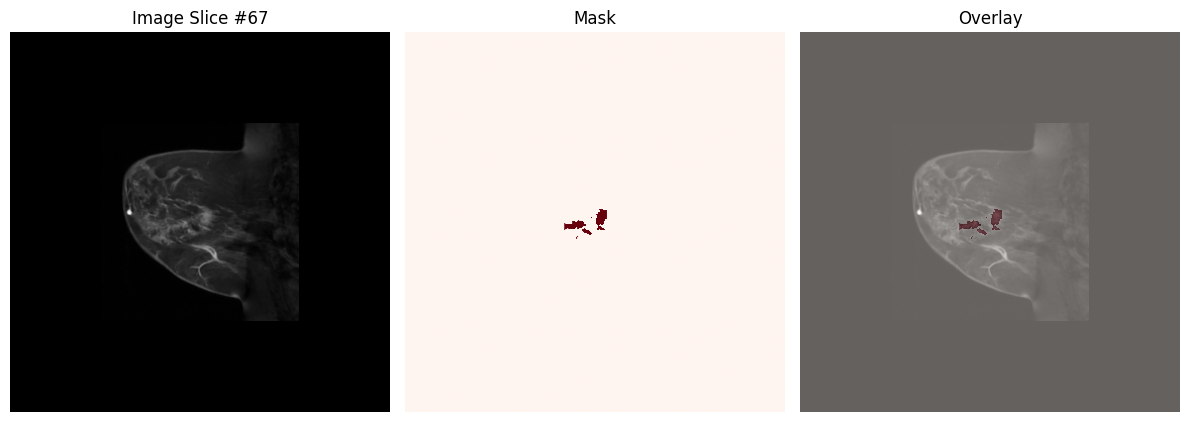

In [5]:
# Cell 4: Plot a slice with non-empty mask
slice_idx, slice_tensor = slices[0]  # Change index to inspect different slices

image = slice_tensor[0].numpy()
mask = slice_tensor[1].numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title(f"Image Slice #{slice_idx}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='Reds')
plt.title("Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='Reds', alpha=0.4)  # Overlay
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Cell 2: Utility functions
def load_sitk(path):
    img_sitk = sitk.ReadImage(path)
    img_np = sitk.GetArrayFromImage(img_sitk)  # shape: [Z, Y, X]
    return img_sitk, img_np

def plot_slice_comparison(original, augmented, slice_idx, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(original[slice_idx], cmap='gray')
    axes[0].set_title(f'Original {title} (Z={slice_idx})')
    axes[0].axis('off')

    axes[1].imshow(augmented[slice_idx], cmap='gray')
    axes[1].set_title(f'Augmented {title} (Z={slice_idx})')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 3: Load image and mask
pid = "ISPY1_1097"  # <- Replace with a real patient ID
img_path = f"../preprocessed/{pid}/{pid}_n4_denoised_resampled_padded.nii.gz"
mask_path = f"../preprocessed/{pid}/{pid}_mask_resampled_padded.nii.gz"

image_sitk, image = load_sitk(img_path)
mask_sitk, mask = load_sitk(mask_path)

print("Image shape:", image.shape)  # [Z, Y, X]
print("Mask shape:", mask.shape)


In [10]:
# Cell 4: Define MONAI 3D transforms
transforms = Compose([
    RandFlipd(keys=["image", "mask"], prob=1.0, spatial_axis=[1]),
    RandAffined(
        keys=["image", "mask"],
        prob=1.0,
        rotate_range=(np.deg2rad(30), 0, 0),
        scale_range=(0.2, 0.2, 0.2),
        translate_range=(20, 20, 20),
        mode=("bilinear", "nearest")
    ),
    Rand3DElasticd(
        keys=["image", "mask"],
        sigma_range=(8, 12),
        magnitude_range=(60, 120),
        prob=1.0,
        mode=("bilinear", "nearest"),
        padding_mode="reflection",
        spatial_size=None
    )
])


In [11]:
# Cell 5: Apply transforms to the full volume
image_3d = image[None, ...]  # Add channel dimension -> [1, Z, Y, X]
mask_3d = mask[None, ...]    # Add channel dimension

batch = {"image": image_3d, "mask": mask_3d}
aug_batch = transforms(batch)

aug_image = aug_batch["image"][0]  # Remove channel dim -> [Z, Y, X]
aug_mask = aug_batch["mask"][0]
